In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-11-17 12:02:37.360097: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2011'
start_month = '06'
end_year = '2011'
end_month = '09'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)

cores = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*96)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in input data- TIR and historical core data at t<to
#core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
#ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
#cores = ds['msg_cores'].values# uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
#tir = ds['msg_Tir'].values/10000 # uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR          
#time_core = ds['time']# (core_filename[-15:-3])


In [7]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        if y==1:
            for m in range(int(start_month),10,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
                y=y+1
                month=[]
            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)    
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

11712


In [8]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010000.nc
0
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010015.nc
1
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010030.nc
2
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010045.nc
3
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010100.nc
4
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010115.nc
5
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010130.nc
6
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010145.nc
7
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010200.nc
8
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010215.nc
9
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010230.nc
10
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010245.nc
11
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010300.nc
12
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010315.nc
13
/prj/nflics/hist_cores/2011/06/01/Hist_cores_wa_201106010330.nc
14
/prj/

123
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020700.nc
124
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020715.nc
125
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020730.nc
126
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020745.nc
127
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020800.nc
128
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020815.nc
129
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020830.nc
130
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020845.nc
131
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020900.nc
132
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020915.nc
133
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020930.nc
134
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106020945.nc
135
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106021000.nc
136
/prj/nflics/hist_cores/2011/06/02/Hist_cores_wa_201106021015.nc
137
/prj/nflics/hist_cores/2011/06/02/Hist_cores

246
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031345.nc
247
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031400.nc
248
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031415.nc
249
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031430.nc
250
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031445.nc
251
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031500.nc
252
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031515.nc
253
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031530.nc
254
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031545.nc
255
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031600.nc
256
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031615.nc
257
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031630.nc
258
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031645.nc
259
/prj/nflics/hist_cores/2011/06/03/Hist_cores_wa_201106031700.nc
260
/prj/nflics/hist_cores/2011/06/03/Hist_cores

367
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042000.nc
368
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042015.nc
369
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042030.nc
370
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042045.nc
371
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042100.nc
372
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042115.nc
373
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042130.nc
374
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042145.nc
375
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042200.nc
376
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042215.nc
377
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042230.nc
378
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042245.nc
379
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042300.nc
380
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042315.nc
381
/prj/nflics/hist_cores/2011/06/04/Hist_cores

490
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060245.nc
491
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060300.nc
492
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060315.nc
493
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060330.nc
494
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060345.nc
495
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060400.nc
496
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060415.nc
497
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060430.nc
498
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060445.nc
499
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060500.nc
500
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060515.nc
501
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060530.nc
502
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060545.nc
503
/prj/nflics/hist_cores/2011/06/06/Hist_cores_wa_201106060600.nc
504
/prj/nflics/hist_cores/2011/06/06/Hist_cores

/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106070900.nc
612
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106070915.nc
613
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106070930.nc
614
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106070945.nc
615
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071000.nc
616
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071015.nc
617
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071030.nc
618
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071045.nc
619
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071100.nc
620
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071115.nc
621
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071130.nc
622
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071145.nc
623
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071200.nc
624
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_201106071215.nc
625
/prj/nflics/hist_cores/2011/06/07/Hist_cores_wa_

/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081530.nc
734
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081545.nc
735
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081600.nc
736
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081615.nc
737
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081630.nc
738
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081645.nc
739
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081700.nc
740
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081715.nc
741
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081730.nc
742
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081745.nc
743
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081800.nc
744
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081815.nc
745
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081830.nc
746
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_201106081845.nc
747
/prj/nflics/hist_cores/2011/06/08/Hist_cores_wa_

856
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092215.nc
857
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092230.nc
858
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092245.nc
859
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092300.nc
860
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092315.nc
861
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092330.nc
862
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092345.nc
863
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100000.nc
864
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100015.nc
865
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100030.nc
866
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100045.nc
867
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100100.nc
868
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100115.nc
869
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100130.nc
870
/prj/nflics/hist_cores/2011/06/10/Hist_cores

/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110445.nc
979
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110500.nc
980
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110515.nc
981
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110530.nc
982
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110545.nc
983
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110600.nc
984
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110615.nc
985
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110630.nc
986
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110645.nc
987
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110700.nc
988
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110715.nc
989
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110730.nc
990
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110745.nc
991
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_201106110800.nc
992
/prj/nflics/hist_cores/2011/06/11/Hist_cores_wa_

1098
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121045.nc
1099
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121100.nc
1100
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121115.nc
1101
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121130.nc
1102
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121145.nc
1103
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121200.nc
1104
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121215.nc
1105
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121230.nc
1106
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121245.nc
1107
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121300.nc
1108
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121315.nc
1109
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121330.nc
1110
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121345.nc
1111
/prj/nflics/hist_cores/2011/06/12/Hist_cores_wa_201106121400.nc
1112
/prj/nflics/hist_cores/2011/0

1218
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131645.nc
1219
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131700.nc
1220
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131715.nc
1221
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131730.nc
1222
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131745.nc
1223
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131800.nc
1224
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131815.nc
1225
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131830.nc
1226
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131845.nc
1227
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131900.nc
1228
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131915.nc
1229
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131930.nc
1230
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106131945.nc
1231
/prj/nflics/hist_cores/2011/06/13/Hist_cores_wa_201106132000.nc
1232
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142230.nc
1338
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142245.nc
1339
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142300.nc
1340
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142315.nc
1341
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142330.nc
1342
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142345.nc
1343
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150000.nc
1344
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150015.nc
1345
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150030.nc
1346
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150045.nc
1347
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150100.nc
1348
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150115.nc
1349
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150130.nc
1350
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150145.nc
1351
/prj/nflics/hist_cores/2011/06/15/

/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160415.nc
1457
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160430.nc
1458
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160445.nc
1459
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160500.nc
1460
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160515.nc
1461
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160530.nc
1462
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160545.nc
1463
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160600.nc
1464
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160615.nc
1465
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160630.nc
1466
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160645.nc
1467
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160700.nc
1468
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160715.nc
1469
/prj/nflics/hist_cores/2011/06/16/Hist_cores_wa_201106160730.nc
1470
/prj/nflics/hist_cores/2011/06/16/

1575
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171000.nc
1576
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171015.nc
1577
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171030.nc
1578
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171045.nc
1579
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171100.nc
1580
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171115.nc
1581
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171130.nc
1582
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171145.nc
1583
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171200.nc
1584
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171215.nc
1585
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171230.nc
1586
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171245.nc
1587
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171300.nc
1588
/prj/nflics/hist_cores/2011/06/17/Hist_cores_wa_201106171315.nc
1589
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181600.nc
1696
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181615.nc
1697
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181630.nc
1698
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181645.nc
1699
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181700.nc
1700
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181715.nc
1701
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181730.nc
1702
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181745.nc
1703
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181800.nc
1704
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181815.nc
1705
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181830.nc
1706
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181845.nc
1707
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181900.nc
1708
/prj/nflics/hist_cores/2011/06/18/Hist_cores_wa_201106181915.nc
1709
/prj/nflics/hist_cores/2011/06/18/

/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192145.nc
1815
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192200.nc
1816
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192215.nc
1817
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192230.nc
1818
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192245.nc
1819
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192300.nc
1820
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192315.nc
1821
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192330.nc
1822
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192345.nc
1823
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200000.nc
1824
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200015.nc
1825
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200030.nc
1826
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200045.nc
1827
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200100.nc
1828
/prj/nflics/hist_cores/2011/06/20/

1933
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210330.nc
1934
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210345.nc
1935
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210400.nc
1936
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210415.nc
1937
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210430.nc
1938
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210445.nc
1939
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210500.nc
1940
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210515.nc
1941
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210530.nc
1942
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210545.nc
1943
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210600.nc
1944
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210615.nc
1945
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210630.nc
1946
/prj/nflics/hist_cores/2011/06/21/Hist_cores_wa_201106210645.nc
1947
/prj/nflics/hist_cores/2011/0

2052
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106220915.nc
2053
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106220930.nc
2054
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106220945.nc
2055
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221000.nc
2056
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221015.nc
2057
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221030.nc
2058
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221045.nc
2059
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221100.nc
2060
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221115.nc
2061
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221130.nc
2062
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221145.nc
2063
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221200.nc
2064
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221215.nc
2065
/prj/nflics/hist_cores/2011/06/22/Hist_cores_wa_201106221230.nc
2066
/prj/nflics/hist_cores/2011/0

2171
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231500.nc
2172
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231515.nc
2173
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231530.nc
2174
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231545.nc
2175
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231600.nc
2176
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231615.nc
2177
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231630.nc
2178
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231645.nc
2179
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231700.nc
2180
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231715.nc
2181
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231730.nc
2182
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231745.nc
2183
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231800.nc
2184
/prj/nflics/hist_cores/2011/06/23/Hist_cores_wa_201106231815.nc
2185
/prj/nflics/hist_cores/2011/0

2291
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242100.nc
2292
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242115.nc
2293
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242130.nc
2294
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242145.nc
2295
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242200.nc
2296
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242215.nc
2297
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242230.nc
2298
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242245.nc
2299
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242300.nc
2300
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242315.nc
2301
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242330.nc
2302
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242345.nc
2303
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250000.nc
2304
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250015.nc
2305
/prj/nflics/hist_cores/2011/0

2410
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260245.nc
2411
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260300.nc
2412
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260315.nc
2413
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260330.nc
2414
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260345.nc
2415
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260400.nc
2416
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260415.nc
2417
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260430.nc
2418
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260445.nc
2419
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260500.nc
2420
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260515.nc
2421
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260530.nc
2422
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260545.nc
2423
/prj/nflics/hist_cores/2011/06/26/Hist_cores_wa_201106260600.nc
2424
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106270830.nc
2530
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106270845.nc
2531
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106270900.nc
2532
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106270915.nc
2533
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106270930.nc
2534
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106270945.nc
2535
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106271000.nc
2536
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106271015.nc
2537
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106271030.nc
2538
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106271045.nc
2539
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106271100.nc
2540
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106271115.nc
2541
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106271130.nc
2542
/prj/nflics/hist_cores/2011/06/27/Hist_cores_wa_201106271145.nc
2543
/prj/nflics/hist_cores/2011/06/27/

2649
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281430.nc
2650
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281445.nc
2651
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281500.nc
2652
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281515.nc
2653
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281530.nc
2654
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281545.nc
2655
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281600.nc
2656
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281615.nc
2657
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281630.nc
2658
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281645.nc
2659
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281700.nc
2660
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281715.nc
2661
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281730.nc
2662
/prj/nflics/hist_cores/2011/06/28/Hist_cores_wa_201106281745.nc
2663
/prj/nflics/hist_cores/2011/0

2768
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292015.nc
2769
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292030.nc
2770
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292045.nc
2771
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292100.nc
2772
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292115.nc
2773
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292130.nc
2774
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292145.nc
2775
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292200.nc
2776
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292215.nc
2777
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292230.nc
2778
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292245.nc
2779
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292300.nc
2780
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292315.nc
2781
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292330.nc
2782
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010200.nc
2888
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010215.nc
2889
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010230.nc
2890
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010245.nc
2891
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010300.nc
2892
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010315.nc
2893
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010330.nc
2894
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010345.nc
2895
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010400.nc
2896
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010415.nc
2897
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010430.nc
2898
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010445.nc
2899
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010500.nc
2900
/prj/nflics/hist_cores/2011/07/01/Hist_cores_wa_201107010515.nc
2901
/prj/nflics/hist_cores/2011/07/01/

3006
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107020745.nc
3007
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107020800.nc
3008
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107020815.nc
3009
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107020830.nc
3010
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107020845.nc
3011
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107020900.nc
3012
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107020915.nc
3013
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107020930.nc
3014
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107020945.nc
3015
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107021000.nc
3016
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107021015.nc
3017
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107021030.nc
3018
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107021045.nc
3019
/prj/nflics/hist_cores/2011/07/02/Hist_cores_wa_201107021100.nc
3020
/prj/nflics/hist_cores/2011/0

3126
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031345.nc
3127
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031400.nc
3128
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031415.nc
3129
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031430.nc
3130
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031445.nc
3131
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031500.nc
3132
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031515.nc
3133
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031530.nc
3134
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031545.nc
3135
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031600.nc
3136
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031615.nc
3137
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031630.nc
3138
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031645.nc
3139
/prj/nflics/hist_cores/2011/07/03/Hist_cores_wa_201107031700.nc
3140
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041930.nc
3246
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041945.nc
3247
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042000.nc
3248
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042015.nc
3249
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042030.nc
3250
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042045.nc
3251
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042100.nc
3252
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042115.nc
3253
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042130.nc
3254
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042145.nc
3255
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042200.nc
3256
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042215.nc
3257
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042230.nc
3258
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042245.nc
3259
/prj/nflics/hist_cores/2011/07/04/

3365
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060130.nc
3366
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060145.nc
3367
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060200.nc
3368
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060215.nc
3369
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060230.nc
3370
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060245.nc
3371
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060300.nc
3372
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060315.nc
3373
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060330.nc
3374
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060345.nc
3375
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060400.nc
3376
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060415.nc
3377
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060430.nc
3378
/prj/nflics/hist_cores/2011/07/06/Hist_cores_wa_201107060445.nc
3379
/prj/nflics/hist_cores/2011/0

3485
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070730.nc
3486
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070745.nc
3487
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070800.nc
3488
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070815.nc
3489
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070830.nc
3490
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070845.nc
3491
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070900.nc
3492
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070915.nc
3493
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070930.nc
3494
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107070945.nc
3495
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107071000.nc
3496
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107071015.nc
3497
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107071030.nc
3498
/prj/nflics/hist_cores/2011/07/07/Hist_cores_wa_201107071045.nc
3499
/prj/nflics/hist_cores/2011/0

3605
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081330.nc
3606
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081345.nc
3607
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081400.nc
3608
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081415.nc
3609
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081430.nc
3610
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081445.nc
3611
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081500.nc
3612
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081515.nc
3613
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081530.nc
3614
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081545.nc
3615
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081600.nc
3616
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081615.nc
3617
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081630.nc
3618
/prj/nflics/hist_cores/2011/07/08/Hist_cores_wa_201107081645.nc
3619
/prj/nflics/hist_cores/2011/0

3724
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091915.nc
3725
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091930.nc
3726
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091945.nc
3727
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092000.nc
3728
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092015.nc
3729
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092030.nc
3730
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092045.nc
3731
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092100.nc
3732
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092115.nc
3733
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092130.nc
3734
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092145.nc
3735
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092200.nc
3736
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092215.nc
3737
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092230.nc
3738
/prj/nflics/hist_cores/2011/0

3844
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110115.nc
3845
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110130.nc
3846
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110145.nc
3847
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110200.nc
3848
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110215.nc
3849
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110230.nc
3850
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110245.nc
3851
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110300.nc
3852
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110315.nc
3853
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110330.nc
3854
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110345.nc
3855
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110400.nc
3856
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110415.nc
3857
/prj/nflics/hist_cores/2011/07/11/Hist_cores_wa_201107110430.nc
3858
/prj/nflics/hist_cores/2011/0

3963
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120700.nc
3964
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120715.nc
3965
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120730.nc
3966
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120745.nc
3967
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120800.nc
3968
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120815.nc
3969
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120830.nc
3970
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120845.nc
3971
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120900.nc
3972
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120915.nc
3973
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120930.nc
3974
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107120945.nc
3975
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107121000.nc
3976
/prj/nflics/hist_cores/2011/07/12/Hist_cores_wa_201107121015.nc
3977
/prj/nflics/hist_cores/2011/0

4082
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131245.nc
4083
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131300.nc
4084
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131315.nc
4085
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131330.nc
4086
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131345.nc
4087
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131400.nc
4088
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131415.nc
4089
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131430.nc
4090
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131445.nc
4091
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131500.nc
4092
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131515.nc
4093
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131530.nc
4094
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131545.nc
4095
/prj/nflics/hist_cores/2011/07/13/Hist_cores_wa_201107131600.nc
4096
/prj/nflics/hist_cores/2011/0

4201
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141830.nc
4202
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141845.nc
4203
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141900.nc
4204
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141915.nc
4205
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141930.nc
4206
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141945.nc
4207
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142000.nc
4208
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142015.nc
4209
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142030.nc
4210
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142045.nc
4211
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142100.nc
4212
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142115.nc
4213
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142130.nc
4214
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142145.nc
4215
/prj/nflics/hist_cores/2011/0

4321
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160030.nc
4322
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160045.nc
4323
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160100.nc
4324
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160115.nc
4325
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160130.nc
4326
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160145.nc
4327
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160200.nc
4328
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160215.nc
4329
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160230.nc
4330
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160245.nc
4331
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160300.nc
4332
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160315.nc
4333
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160330.nc
4334
/prj/nflics/hist_cores/2011/07/16/Hist_cores_wa_201107160345.nc
4335
/prj/nflics/hist_cores/2011/0

4440
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170615.nc
4441
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170630.nc
4442
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170645.nc
4443
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170700.nc
4444
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170715.nc
4445
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170730.nc
4446
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170745.nc
4447
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170800.nc
4448
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170815.nc
4449
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170830.nc
4450
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170845.nc
4451
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170900.nc
4452
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170915.nc
4453
/prj/nflics/hist_cores/2011/07/17/Hist_cores_wa_201107170930.nc
4454
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181200.nc
4560
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181215.nc
4561
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181230.nc
4562
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181245.nc
4563
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181300.nc
4564
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181315.nc
4565
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181330.nc
4566
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181345.nc
4567
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181400.nc
4568
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181415.nc
4569
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181430.nc
4570
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181445.nc
4571
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181500.nc
4572
/prj/nflics/hist_cores/2011/07/18/Hist_cores_wa_201107181515.nc
4573
/prj/nflics/hist_cores/2011/07/18/

/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191745.nc
4679
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191800.nc
4680
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191815.nc
4681
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191830.nc
4682
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191845.nc
4683
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191900.nc
4684
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191915.nc
4685
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191930.nc
4686
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191945.nc
4687
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192000.nc
4688
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192015.nc
4689
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192030.nc
4690
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192045.nc
4691
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192100.nc
4692
/prj/nflics/hist_cores/2011/07/19/

4798
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107202345.nc
4799
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210000.nc
4800
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210015.nc
4801
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210030.nc
4802
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210045.nc
4803
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210100.nc
4804
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210115.nc
4805
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210130.nc
4806
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210145.nc
4807
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210200.nc
4808
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210215.nc
4809
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210230.nc
4810
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210245.nc
4811
/prj/nflics/hist_cores/2011/07/21/Hist_cores_wa_201107210300.nc
4812
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220530.nc
4918
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220545.nc
4919
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220600.nc
4920
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220615.nc
4921
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220630.nc
4922
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220645.nc
4923
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220700.nc
4924
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220715.nc
4925
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220730.nc
4926
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220745.nc
4927
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220800.nc
4928
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220815.nc
4929
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220830.nc
4930
/prj/nflics/hist_cores/2011/07/22/Hist_cores_wa_201107220845.nc
4931
/prj/nflics/hist_cores/2011/07/22/

5038
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231145.nc
5039
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231200.nc
5040
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231215.nc
5041
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231230.nc
5042
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231245.nc
5043
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231300.nc
5044
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231315.nc
5045
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231330.nc
5046
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231345.nc
5047
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231400.nc
5048
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231415.nc
5049
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231430.nc
5050
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231445.nc
5051
/prj/nflics/hist_cores/2011/07/23/Hist_cores_wa_201107231500.nc
5052
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241730.nc
5158
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241745.nc
5159
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241800.nc
5160
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241815.nc
5161
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241830.nc
5162
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241845.nc
5163
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241900.nc
5164
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241915.nc
5165
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241930.nc
5166
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241945.nc
5167
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107242000.nc
5168
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107242015.nc
5169
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107242030.nc
5170
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107242045.nc
5171
/prj/nflics/hist_cores/2011/07/24/

5276
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107252315.nc
5277
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107252330.nc
5278
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107252345.nc
5279
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260000.nc
5280
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260015.nc
5281
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260030.nc
5282
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260045.nc
5283
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260100.nc
5284
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260115.nc
5285
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260130.nc
5286
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260145.nc
5287
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260200.nc
5288
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260215.nc
5289
/prj/nflics/hist_cores/2011/07/26/Hist_cores_wa_201107260230.nc
5290
/prj/nflics/hist_cores/2011/0

5395
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270500.nc
5396
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270515.nc
5397
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270530.nc
5398
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270545.nc
5399
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270600.nc
5400
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270615.nc
5401
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270630.nc
5402
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270645.nc
5403
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270700.nc
5404
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270715.nc
5405
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270730.nc
5406
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270745.nc
5407
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270800.nc
5408
/prj/nflics/hist_cores/2011/07/27/Hist_cores_wa_201107270815.nc
5409
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281100.nc
5516
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281115.nc
5517
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281130.nc
5518
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281145.nc
5519
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281200.nc
5520
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281215.nc
5521
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281230.nc
5522
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281245.nc
5523
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281300.nc
5524
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281315.nc
5525
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281330.nc
5526
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281345.nc
5527
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281400.nc
5528
/prj/nflics/hist_cores/2011/07/28/Hist_cores_wa_201107281415.nc
5529
/prj/nflics/hist_cores/2011/07/28/

5636
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291715.nc
5637
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291730.nc
5638
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291745.nc
5639
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291800.nc
5640
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291815.nc
5641
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291830.nc
5642
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291845.nc
5643
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291900.nc
5644
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291915.nc
5645
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291930.nc
5646
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291945.nc
5647
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107292000.nc
5648
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107292015.nc
5649
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107292030.nc
5650
/prj/nflics/hist_cores/2011/0

5755
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107302300.nc
5756
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107302315.nc
5757
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107302330.nc
5758
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107302345.nc
5759
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310000.nc
5760
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310015.nc
5761
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310030.nc
5762
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310045.nc
5763
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310100.nc
5764
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310115.nc
5765
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310130.nc
5766
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310145.nc
5767
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310200.nc
5768
/prj/nflics/hist_cores/2011/07/31/Hist_cores_wa_201107310215.nc
5769
/prj/nflics/hist_cores/2011/0

5875
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010500.nc
5876
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010515.nc
5877
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010530.nc
5878
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010545.nc
5879
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010600.nc
5880
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010615.nc
5881
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010630.nc
5882
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010645.nc
5883
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010700.nc
5884
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010715.nc
5885
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010730.nc
5886
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010745.nc
5887
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010800.nc
5888
/prj/nflics/hist_cores/2011/08/01/Hist_cores_wa_201108010815.nc
5889
/prj/nflics/hist_cores/2011/0

5994
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021045.nc
5995
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021100.nc
5996
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021115.nc
5997
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021130.nc
5998
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021145.nc
5999
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021200.nc
6000
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021215.nc
6001
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021230.nc
6002
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021245.nc
6003
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021300.nc
6004
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021315.nc
6005
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021330.nc
6006
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021345.nc
6007
/prj/nflics/hist_cores/2011/08/02/Hist_cores_wa_201108021400.nc
6008
/prj/nflics/hist_cores/2011/0

6114
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031645.nc
6115
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031700.nc
6116
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031715.nc
6117
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031730.nc
6118
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031745.nc
6119
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031800.nc
6120
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031815.nc
6121
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031830.nc
6122
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031845.nc
6123
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031900.nc
6124
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031915.nc
6125
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031930.nc
6126
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031945.nc
6127
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108032000.nc
6128
/prj/nflics/hist_cores/2011/0

6233
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108042230.nc
6234
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108042245.nc
6235
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108042300.nc
6236
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108042315.nc
6237
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108042330.nc
6238
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108042345.nc
6239
/prj/nflics/hist_cores/2011/08/05/Hist_cores_wa_201108050000.nc
6240
/prj/nflics/hist_cores/2011/08/05/Hist_cores_wa_201108050015.nc
6241
/prj/nflics/hist_cores/2011/08/05/Hist_cores_wa_201108050030.nc
6242
/prj/nflics/hist_cores/2011/08/05/Hist_cores_wa_201108050045.nc
6243
/prj/nflics/hist_cores/2011/08/05/Hist_cores_wa_201108050100.nc
6244
/prj/nflics/hist_cores/2011/08/05/Hist_cores_wa_201108050115.nc
6245
/prj/nflics/hist_cores/2011/08/05/Hist_cores_wa_201108050130.nc
6246
/prj/nflics/hist_cores/2011/08/05/Hist_cores_wa_201108050145.nc
6247
/prj/nflics/hist_cores/2011/0

6353
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060430.nc
6354
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060445.nc
6355
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060500.nc
6356
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060515.nc
6357
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060530.nc
6358
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060545.nc
6359
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060600.nc
6360
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060615.nc
6361
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060630.nc
6362
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060645.nc
6363
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060700.nc
6364
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060715.nc
6365
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060730.nc
6366
/prj/nflics/hist_cores/2011/08/06/Hist_cores_wa_201108060745.nc
6367
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071030.nc
6474
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071045.nc
6475
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071100.nc
6476
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071115.nc
6477
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071130.nc
6478
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071145.nc
6479
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071200.nc
6480
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071215.nc
6481
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071230.nc
6482
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071245.nc
6483
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071300.nc
6484
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071315.nc
6485
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071330.nc
6486
/prj/nflics/hist_cores/2011/08/07/Hist_cores_wa_201108071345.nc
6487
/prj/nflics/hist_cores/2011/08/07/

/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081630.nc
6594
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081645.nc
6595
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081700.nc
6596
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081715.nc
6597
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081730.nc
6598
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081745.nc
6599
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081800.nc
6600
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081815.nc
6601
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081830.nc
6602
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081845.nc
6603
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081900.nc
6604
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081915.nc
6605
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081930.nc
6606
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081945.nc
6607
/prj/nflics/hist_cores/2011/08/08/

6714
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108092245.nc
6715
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108092300.nc
6716
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108092315.nc
6717
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108092330.nc
6718
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108092345.nc
6719
/prj/nflics/hist_cores/2011/08/10/Hist_cores_wa_201108100000.nc
6720
/prj/nflics/hist_cores/2011/08/10/Hist_cores_wa_201108100015.nc
6721
/prj/nflics/hist_cores/2011/08/10/Hist_cores_wa_201108100030.nc
6722
/prj/nflics/hist_cores/2011/08/10/Hist_cores_wa_201108100045.nc
6723
/prj/nflics/hist_cores/2011/08/10/Hist_cores_wa_201108100100.nc
6724
/prj/nflics/hist_cores/2011/08/10/Hist_cores_wa_201108100115.nc
6725
/prj/nflics/hist_cores/2011/08/10/Hist_cores_wa_201108100130.nc
6726
/prj/nflics/hist_cores/2011/08/10/Hist_cores_wa_201108100145.nc
6727
/prj/nflics/hist_cores/2011/08/10/Hist_cores_wa_201108100200.nc
6728
/prj/nflics/hist_cores/2011/0

6834
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110445.nc
6835
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110500.nc
6836
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110515.nc
6837
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110530.nc
6838
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110545.nc
6839
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110600.nc
6840
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110615.nc
6841
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110630.nc
6842
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110645.nc
6843
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110700.nc
6844
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110715.nc
6845
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110730.nc
6846
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110745.nc
6847
/prj/nflics/hist_cores/2011/08/11/Hist_cores_wa_201108110800.nc
6848
/prj/nflics/hist_cores/2011/0

6953
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121030.nc
6954
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121045.nc
6955
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121100.nc
6956
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121115.nc
6957
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121130.nc
6958
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121145.nc
6959
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121200.nc
6960
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121215.nc
6961
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121230.nc
6962
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121245.nc
6963
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121300.nc
6964
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121315.nc
6965
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121330.nc
6966
/prj/nflics/hist_cores/2011/08/12/Hist_cores_wa_201108121345.nc
6967
/prj/nflics/hist_cores/2011/0

7074
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131645.nc
7075
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131700.nc
7076
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131715.nc
7077
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131730.nc
7078
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131745.nc
7079
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131800.nc
7080
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131815.nc
7081
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131830.nc
7082
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131845.nc
7083
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131900.nc
7084
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131915.nc
7085
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131930.nc
7086
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131945.nc
7087
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108132000.nc
7088
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108142245.nc
7195
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108142300.nc
7196
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108142315.nc
7197
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108142330.nc
7198
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108142345.nc
7199
/prj/nflics/hist_cores/2011/08/15/Hist_cores_wa_201108150000.nc
7200
/prj/nflics/hist_cores/2011/08/15/Hist_cores_wa_201108150015.nc
7201
/prj/nflics/hist_cores/2011/08/15/Hist_cores_wa_201108150030.nc
7202
/prj/nflics/hist_cores/2011/08/15/Hist_cores_wa_201108150045.nc
7203
/prj/nflics/hist_cores/2011/08/15/Hist_cores_wa_201108150100.nc
7204
/prj/nflics/hist_cores/2011/08/15/Hist_cores_wa_201108150115.nc
7205
/prj/nflics/hist_cores/2011/08/15/Hist_cores_wa_201108150130.nc
7206
/prj/nflics/hist_cores/2011/08/15/Hist_cores_wa_201108150145.nc
7207
/prj/nflics/hist_cores/2011/08/15/Hist_cores_wa_201108150200.nc
7208
/prj/nflics/hist_cores/2011/08/15/

7314
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160445.nc
7315
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160500.nc
7316
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160515.nc
7317
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160530.nc
7318
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160545.nc
7319
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160600.nc
7320
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160615.nc
7321
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160630.nc
7322
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160645.nc
7323
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160700.nc
7324
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160715.nc
7325
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160730.nc
7326
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160745.nc
7327
/prj/nflics/hist_cores/2011/08/16/Hist_cores_wa_201108160800.nc
7328
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171045.nc
7435
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171100.nc
7436
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171115.nc
7437
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171130.nc
7438
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171145.nc
7439
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171200.nc
7440
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171215.nc
7441
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171230.nc
7442
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171245.nc
7443
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171300.nc
7444
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171315.nc
7445
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171330.nc
7446
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171345.nc
7447
/prj/nflics/hist_cores/2011/08/17/Hist_cores_wa_201108171400.nc
7448
/prj/nflics/hist_cores/2011/08/17/

/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181630.nc
7554
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181645.nc
7555
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181700.nc
7556
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181715.nc
7557
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181730.nc
7558
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181745.nc
7559
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181800.nc
7560
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181815.nc
7561
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181830.nc
7562
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181845.nc
7563
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181900.nc
7564
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181915.nc
7565
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181930.nc
7566
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181945.nc
7567
/prj/nflics/hist_cores/2011/08/18/

7672
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108192215.nc
7673
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108192230.nc
7674
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108192245.nc
7675
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108192300.nc
7676
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108192315.nc
7677
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108192330.nc
7678
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108192345.nc
7679
/prj/nflics/hist_cores/2011/08/20/Hist_cores_wa_201108200000.nc
7680
/prj/nflics/hist_cores/2011/08/20/Hist_cores_wa_201108200015.nc
7681
/prj/nflics/hist_cores/2011/08/20/Hist_cores_wa_201108200030.nc
7682
/prj/nflics/hist_cores/2011/08/20/Hist_cores_wa_201108200045.nc
7683
/prj/nflics/hist_cores/2011/08/20/Hist_cores_wa_201108200100.nc
7684
/prj/nflics/hist_cores/2011/08/20/Hist_cores_wa_201108200115.nc
7685
/prj/nflics/hist_cores/2011/08/20/Hist_cores_wa_201108200130.nc
7686
/prj/nflics/hist_cores/2011/0

7792
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210415.nc
7793
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210430.nc
7794
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210445.nc
7795
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210500.nc
7796
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210515.nc
7797
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210530.nc
7798
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210545.nc
7799
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210600.nc
7800
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210615.nc
7801
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210630.nc
7802
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210645.nc
7803
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210700.nc
7804
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210715.nc
7805
/prj/nflics/hist_cores/2011/08/21/Hist_cores_wa_201108210730.nc
7806
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221000.nc
7912
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221015.nc
7913
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221030.nc
7914
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221045.nc
7915
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221100.nc
7916
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221115.nc
7917
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221130.nc
7918
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221145.nc
7919
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221200.nc
7920
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221215.nc
7921
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221230.nc
7922
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221245.nc
7923
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221300.nc
7924
/prj/nflics/hist_cores/2011/08/22/Hist_cores_wa_201108221315.nc
7925
/prj/nflics/hist_cores/2011/08/22/

/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231600.nc
8032
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231615.nc
8033
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231630.nc
8034
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231645.nc
8035
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231700.nc
8036
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231715.nc
8037
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231730.nc
8038
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231745.nc
8039
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231800.nc
8040
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231815.nc
8041
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231830.nc
8042
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231845.nc
8043
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231900.nc
8044
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231915.nc
8045
/prj/nflics/hist_cores/2011/08/23/

8151
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108242200.nc
8152
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108242215.nc
8153
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108242230.nc
8154
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108242245.nc
8155
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108242300.nc
8156
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108242315.nc
8157
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108242330.nc
8158
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108242345.nc
8159
/prj/nflics/hist_cores/2011/08/25/Hist_cores_wa_201108250000.nc
8160
/prj/nflics/hist_cores/2011/08/25/Hist_cores_wa_201108250015.nc
8161
/prj/nflics/hist_cores/2011/08/25/Hist_cores_wa_201108250030.nc
8162
/prj/nflics/hist_cores/2011/08/25/Hist_cores_wa_201108250045.nc
8163
/prj/nflics/hist_cores/2011/08/25/Hist_cores_wa_201108250100.nc
8164
/prj/nflics/hist_cores/2011/08/25/Hist_cores_wa_201108250115.nc
8165
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260400.nc
8272
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260415.nc
8273
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260430.nc
8274
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260445.nc
8275
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260500.nc
8276
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260515.nc
8277
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260530.nc
8278
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260545.nc
8279
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260600.nc
8280
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260615.nc
8281
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260630.nc
8282
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260645.nc
8283
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260700.nc
8284
/prj/nflics/hist_cores/2011/08/26/Hist_cores_wa_201108260715.nc
8285
/prj/nflics/hist_cores/2011/08/26/

8392
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271015.nc
8393
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271030.nc
8394
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271045.nc
8395
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271100.nc
8396
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271115.nc
8397
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271130.nc
8398
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271145.nc
8399
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271200.nc
8400
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271215.nc
8401
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271230.nc
8402
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271245.nc
8403
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271300.nc
8404
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271315.nc
8405
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108271330.nc
8406
/prj/nflics/hist_cores/2011/0

8512
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281615.nc
8513
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281630.nc
8514
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281645.nc
8515
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281700.nc
8516
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281715.nc
8517
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281730.nc
8518
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281745.nc
8519
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281800.nc
8520
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281815.nc
8521
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281830.nc
8522
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281845.nc
8523
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281900.nc
8524
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281915.nc
8525
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281930.nc
8526
/prj/nflics/hist_cores/2011/0

8633
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108292230.nc
8634
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108292245.nc
8635
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108292300.nc
8636
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108292315.nc
8637
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108292330.nc
8638
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108292345.nc
8639
/prj/nflics/hist_cores/2011/08/30/Hist_cores_wa_201108300000.nc
8640
/prj/nflics/hist_cores/2011/08/30/Hist_cores_wa_201108300015.nc
8641
/prj/nflics/hist_cores/2011/08/30/Hist_cores_wa_201108300030.nc
8642
/prj/nflics/hist_cores/2011/08/30/Hist_cores_wa_201108300045.nc
8643
/prj/nflics/hist_cores/2011/08/30/Hist_cores_wa_201108300100.nc
8644
/prj/nflics/hist_cores/2011/08/30/Hist_cores_wa_201108300115.nc
8645
/prj/nflics/hist_cores/2011/08/30/Hist_cores_wa_201108300130.nc
8646
/prj/nflics/hist_cores/2011/08/30/Hist_cores_wa_201108300145.nc
8647
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310430.nc
8754
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310445.nc
8755
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310500.nc
8756
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310515.nc
8757
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310530.nc
8758
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310545.nc
8759
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310600.nc
8760
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310615.nc
8761
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310630.nc
8762
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310645.nc
8763
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310700.nc
8764
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310715.nc
8765
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310730.nc
8766
/prj/nflics/hist_cores/2011/08/31/Hist_cores_wa_201108310745.nc
8767
/prj/nflics/hist_cores/2011/08/31/

8873
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011030.nc
8874
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011045.nc
8875
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011100.nc
8876
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011115.nc
8877
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011130.nc
8878
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011145.nc
8879
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011200.nc
8880
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011215.nc
8881
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011230.nc
8882
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011245.nc
8883
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011300.nc
8884
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011315.nc
8885
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011330.nc
8886
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109011345.nc
8887
/prj/nflics/hist_cores/2011/0

8992
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021615.nc
8993
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021630.nc
8994
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021645.nc
8995
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021700.nc
8996
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021715.nc
8997
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021730.nc
8998
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021745.nc
8999
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021800.nc
9000
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021815.nc
9001
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021830.nc
9002
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021845.nc
9003
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021900.nc
9004
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021915.nc
9005
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021930.nc
9006
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109032200.nc
9112
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109032215.nc
9113
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109032230.nc
9114
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109032245.nc
9115
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109032300.nc
9116
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109032315.nc
9117
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109032330.nc
9118
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109032345.nc
9119
/prj/nflics/hist_cores/2011/09/04/Hist_cores_wa_201109040000.nc
9120
/prj/nflics/hist_cores/2011/09/04/Hist_cores_wa_201109040015.nc
9121
/prj/nflics/hist_cores/2011/09/04/Hist_cores_wa_201109040030.nc
9122
/prj/nflics/hist_cores/2011/09/04/Hist_cores_wa_201109040045.nc
9123
/prj/nflics/hist_cores/2011/09/04/Hist_cores_wa_201109040100.nc
9124
/prj/nflics/hist_cores/2011/09/04/Hist_cores_wa_201109040115.nc
9125
/prj/nflics/hist_cores/2011/09/04/

9232
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050415.nc
9233
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050430.nc
9234
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050445.nc
9235
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050500.nc
9236
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050515.nc
9237
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050530.nc
9238
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050545.nc
9239
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050600.nc
9240
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050615.nc
9241
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050630.nc
9242
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050645.nc
9243
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050700.nc
9244
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050715.nc
9245
/prj/nflics/hist_cores/2011/09/05/Hist_cores_wa_201109050730.nc
9246
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061015.nc
9353
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061030.nc
9354
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061045.nc
9355
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061100.nc
9356
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061115.nc
9357
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061130.nc
9358
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061145.nc
9359
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061200.nc
9360
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061215.nc
9361
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061230.nc
9362
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061245.nc
9363
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061300.nc
9364
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061315.nc
9365
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109061330.nc
9366
/prj/nflics/hist_cores/2011/09/06/

/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071615.nc
9473
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071630.nc
9474
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071645.nc
9475
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071700.nc
9476
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071715.nc
9477
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071730.nc
9478
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071745.nc
9479
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071800.nc
9480
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071815.nc
9481
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071830.nc
9482
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071845.nc
9483
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071900.nc
9484
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071915.nc
9485
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071930.nc
9486
/prj/nflics/hist_cores/2011/09/07/

9592
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109082215.nc
9593
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109082230.nc
9594
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109082245.nc
9595
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109082300.nc
9596
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109082315.nc
9597
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109082330.nc
9598
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109082345.nc
9599
/prj/nflics/hist_cores/2011/09/09/Hist_cores_wa_201109090000.nc
9600
/prj/nflics/hist_cores/2011/09/09/Hist_cores_wa_201109090015.nc
9601
/prj/nflics/hist_cores/2011/09/09/Hist_cores_wa_201109090030.nc
9602
/prj/nflics/hist_cores/2011/09/09/Hist_cores_wa_201109090045.nc
9603
/prj/nflics/hist_cores/2011/09/09/Hist_cores_wa_201109090100.nc
9604
/prj/nflics/hist_cores/2011/09/09/Hist_cores_wa_201109090115.nc
9605
/prj/nflics/hist_cores/2011/09/09/Hist_cores_wa_201109090130.nc
9606
/prj/nflics/hist_cores/2011/0

9711
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100400.nc
9712
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100415.nc
9713
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100430.nc
9714
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100445.nc
9715
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100500.nc
9716
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100515.nc
9717
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100530.nc
9718
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100545.nc
9719
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100600.nc
9720
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100615.nc
9721
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100630.nc
9722
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100645.nc
9723
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100700.nc
9724
/prj/nflics/hist_cores/2011/09/10/Hist_cores_wa_201109100715.nc
9725
/prj/nflics/hist_cores/2011/0

9831
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111000.nc
9832
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111015.nc
9833
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111030.nc
9834
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111045.nc
9835
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111100.nc
9836
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111115.nc
9837
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111130.nc
9838
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111145.nc
9839
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111200.nc
9840
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111215.nc
9841
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111230.nc
9842
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111245.nc
9843
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111300.nc
9844
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109111315.nc
9845
/prj/nflics/hist_cores/2011/0

9951
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121600.nc
9952
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121615.nc
9953
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121630.nc
9954
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121645.nc
9955
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121700.nc
9956
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121715.nc
9957
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121730.nc
9958
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121745.nc
9959
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121800.nc
9960
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121815.nc
9961
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121830.nc
9962
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121845.nc
9963
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121900.nc
9964
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121915.nc
9965
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109132145.nc
10071
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109132200.nc
10072
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109132215.nc
10073
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109132230.nc
10074
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109132245.nc
10075
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109132300.nc
10076
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109132315.nc
10077
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109132330.nc
10078
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109132345.nc
10079
/prj/nflics/hist_cores/2011/09/14/Hist_cores_wa_201109140000.nc
10080
/prj/nflics/hist_cores/2011/09/14/Hist_cores_wa_201109140015.nc
10081
/prj/nflics/hist_cores/2011/09/14/Hist_cores_wa_201109140030.nc
10082
/prj/nflics/hist_cores/2011/09/14/Hist_cores_wa_201109140045.nc
10083
/prj/nflics/hist_cores/2011/09/14/Hist_cores_wa_201109140100.nc
10084
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150330.nc
10190
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150345.nc
10191
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150400.nc
10192
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150415.nc
10193
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150430.nc
10194
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150445.nc
10195
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150500.nc
10196
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150515.nc
10197
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150530.nc
10198
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150545.nc
10199
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150600.nc
10200
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150615.nc
10201
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150630.nc
10202
/prj/nflics/hist_cores/2011/09/15/Hist_cores_wa_201109150645.nc
10203
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109160900.nc
10308
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109160915.nc
10309
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109160930.nc
10310
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109160945.nc
10311
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161000.nc
10312
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161015.nc
10313
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161030.nc
10314
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161045.nc
10315
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161100.nc
10316
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161115.nc
10317
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161130.nc
10318
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161145.nc
10319
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161200.nc
10320
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109161215.nc
10321
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171445.nc
10427
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171500.nc
10428
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171515.nc
10429
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171530.nc
10430
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171545.nc
10431
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171600.nc
10432
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171615.nc
10433
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171630.nc
10434
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171645.nc
10435
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171700.nc
10436
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171715.nc
10437
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171730.nc
10438
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171745.nc
10439
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171800.nc
10440
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182030.nc
10546
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182045.nc
10547
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182100.nc
10548
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182115.nc
10549
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182130.nc
10550
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182145.nc
10551
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182200.nc
10552
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182215.nc
10553
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182230.nc
10554
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182245.nc
10555
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182300.nc
10556
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182315.nc
10557
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182330.nc
10558
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109182345.nc
10559
/prj/nflics/hist_cor

10664
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200215.nc
10665
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200230.nc
10666
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200245.nc
10667
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200300.nc
10668
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200315.nc
10669
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200330.nc
10670
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200345.nc
10671
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200400.nc
10672
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200415.nc
10673
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200430.nc
10674
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200445.nc
10675
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200500.nc
10676
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200515.nc
10677
/prj/nflics/hist_cores/2011/09/20/Hist_cores_wa_201109200530.nc
10678
/prj/nflics/hi

10782
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109210745.nc
10783
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109210800.nc
10784
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109210815.nc
10785
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109210830.nc
10786
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109210845.nc
10787
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109210900.nc
10788
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109210915.nc
10789
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109210930.nc
10790
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109210945.nc
10791
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211000.nc
10792
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211015.nc
10793
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211030.nc
10794
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211045.nc
10795
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109211100.nc
10796
/prj/nflics/hi

/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221315.nc
10901
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221330.nc
10902
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221345.nc
10903
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221400.nc
10904
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221415.nc
10905
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221430.nc
10906
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221445.nc
10907
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221500.nc
10908
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221515.nc
10909
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221530.nc
10910
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221545.nc
10911
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221600.nc
10912
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221615.nc
10913
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221630.nc
10914
/prj/nflics/hist_cor

11019
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231900.nc
11020
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231915.nc
11021
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231930.nc
11022
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231945.nc
11023
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232000.nc
11024
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232015.nc
11025
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232030.nc
11026
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232045.nc
11027
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232100.nc
11028
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232115.nc
11029
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232130.nc
11030
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232145.nc
11031
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232200.nc
11032
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109232215.nc
11033
/prj/nflics/hi

/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250030.nc
11138
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250045.nc
11139
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250100.nc
11140
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250115.nc
11141
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250130.nc
11142
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250145.nc
11143
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250200.nc
11144
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250215.nc
11145
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250230.nc
11146
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250245.nc
11147
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250300.nc
11148
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250315.nc
11149
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250330.nc
11150
/prj/nflics/hist_cores/2011/09/25/Hist_cores_wa_201109250345.nc
11151
/prj/nflics/hist_cor

11257
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260630.nc
11258
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260645.nc
11259
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260700.nc
11260
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260715.nc
11261
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260730.nc
11262
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260745.nc
11263
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260800.nc
11264
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260815.nc
11265
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260830.nc
11266
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260845.nc
11267
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260900.nc
11268
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260915.nc
11269
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260930.nc
11270
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109260945.nc
11271
/prj/nflics/hi

/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271215.nc
11377
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271230.nc
11378
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271245.nc
11379
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271300.nc
11380
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271315.nc
11381
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271330.nc
11382
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271345.nc
11383
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271400.nc
11384
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271415.nc
11385
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271430.nc
11386
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271445.nc
11387
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271500.nc
11388
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271515.nc
11389
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271530.nc
11390
/prj/nflics/hist_cor

11494
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281745.nc
11495
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281800.nc
11496
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281815.nc
11497
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281830.nc
11498
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281845.nc
11499
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281900.nc
11500
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281915.nc
11501
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281930.nc
11502
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281945.nc
11503
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109282000.nc
11504
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109282015.nc
11505
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109282030.nc
11506
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109282045.nc
11507
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109282100.nc
11508
/prj/nflics/hi

/prj/nflics/hist_cores/2011/09/29/Hist_cores_wa_201109292315.nc
11613
/prj/nflics/hist_cores/2011/09/29/Hist_cores_wa_201109292330.nc
11614
/prj/nflics/hist_cores/2011/09/29/Hist_cores_wa_201109292345.nc
11615
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300000.nc
11616
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300015.nc
11617
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300030.nc
11618
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300045.nc
11619
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300100.nc
11620
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300115.nc
11621
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300130.nc
11622
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300145.nc
11623
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300200.nc
11624
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300215.nc
11625
/prj/nflics/hist_cores/2011/09/30/Hist_cores_wa_201109300230.nc
11626
/prj/nflics/hist_cor

In [9]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


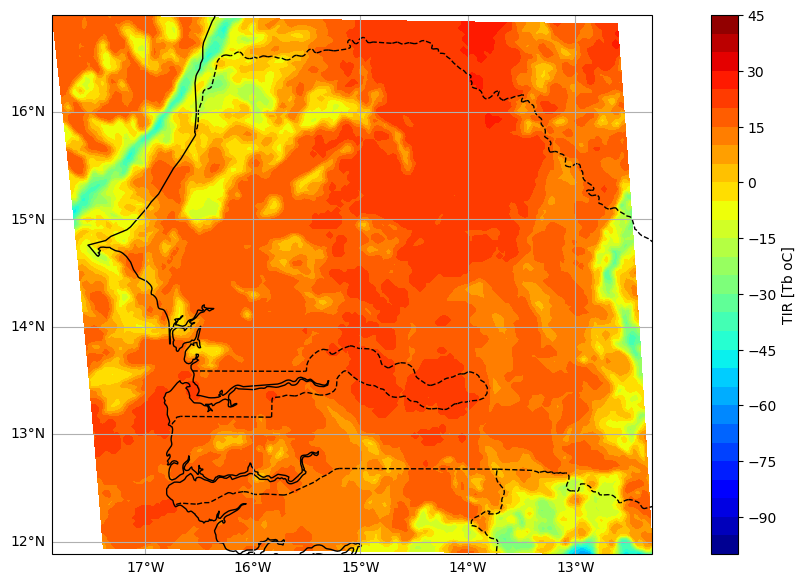

In [10]:
day = 96*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [11]:
# input data
# starting at 
num_frames= 24  # previous 6 hours of images to predict 1 hr later
t0= 1*4 # # 1 hours later (4 frames at 15 min)
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]


#target data
cores_t_plus_xhr = cores[t0+num_frames:,:-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
print(np.unique(cores_t_plus_xhr))



[0. 1.]


In [12]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[:t0+num_frames,:-a,b:]))
#print(np.unique(cores[t0+num_frames:,:-a,b:]))
#print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()
#print(cores_t_plus_xhr[ind])
#print(ind)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


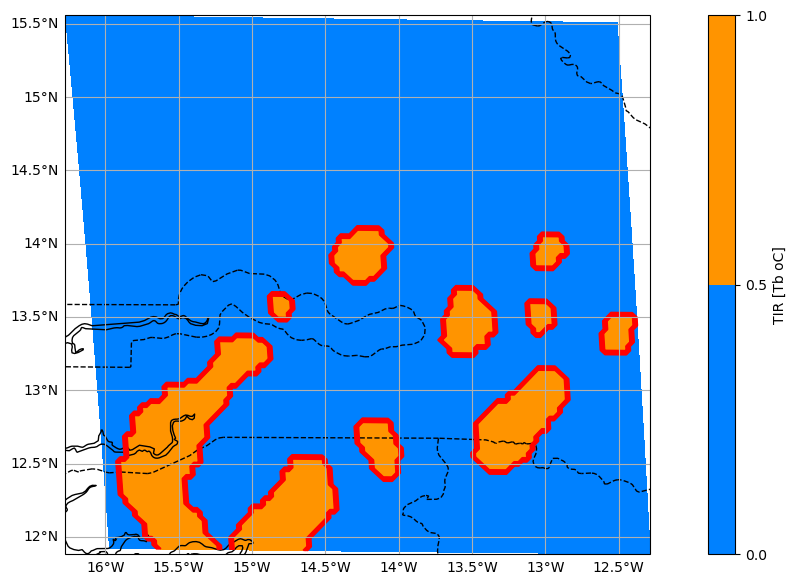

In [13]:
day = t0+num_frames+63  #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day- (t0+num_frames),:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon[:-a,b:], lat[:-a,b:], cores[day,:-a,b:], colors='r')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')

#

In [14]:
print(cores_t_0.shape)
print(cores_t_plus_xhr.shape)
#print(len(lat[:-45,1]))
#print(len(lat[1,48:]))
#print(lat.shape)
#173-128
#176-128

(11684, 128, 128)
(11684, 128, 128)


In [15]:
# save variables 
with open('WA_subdomain_cores.pkl', 'wb') as file: 
          pickle.dump([cores_t_0,tir_t_0,cores_t_plus_xhr], file) 
        

In [16]:
# open a file, where you stored the pickled data
#file = open('WA_subdomain_cores.pkl', 'rb')
#data = pickle.load(file)
#cores_t_0= data[0]
#tir_t_0= data[1]
#cores_t_plus_xhr= data[2]

In [17]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 1 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [18]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=16, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [19]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 128, 128, 1  27264     
                             6)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 128, 128, 1  64       
 ormalization)               6)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 128, 128, 8  6944      
                             )                                   
                                                                 
 batch_normalization_1 (Batc  (None, None, 128, 128, 8  32   

In [20]:
num_frames= 24  # hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
val_samples= 50
x_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
x_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
                   
    
for i in range(0,batch_size-val_samples,1):  
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
    
val_ind= (i+1)*num_frames
    
for i in range(0,val_samples,1):  
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]

           
# normalize input data        
x_train = x_train/np.max(x_train)
x_val = x_val/np.max(x_train)


In [21]:
print(x_train.shape)
print(x_val.shape)
#batch_size-val_samples
#batch_size

(436, 24, 128, 128, 1)
(50, 24, 128, 128, 1)


In [22]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 3 # 20
batch_size = 12 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/6
37/37 [==============================] - 609s 16s/step - loss: 0.4170 - val_loss: 0.4812 - lr: 0.0010
Epoch 2/6
37/37 [==============================] - 631s 17s/step - loss: 0.0734 - val_loss: 0.3245 - lr: 0.0010
Epoch 3/6
37/37 [==============================] - 605s 16s/step - loss: 0.0696 - val_loss: 0.2440 - lr: 0.0010
Epoch 4/6
37/37 [==============================] - 602s 16s/step - loss: 0.0692 - val_loss: 0.1786 - lr: 0.0010
Epoch 5/6
37/37 [==============================] - 603s 16s/step - loss: 0.0686 - val_loss: 0.1392 - lr: 0.0010
Epoch 6/6
37/37 [==============================] - 603s 16s/step - loss: 0.0684 - val_loss: 0.1274 - lr: 0.0010


In [23]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)
with open('WA_subdomain_trained_model.pkl', 'wb') as file: 
    pickle.dump(model, file) 
        

In [24]:
#print(x_val.shape)
#print(predicted_frame.shape)
#print(np.where(all_frames>0.35))

In [54]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
# using x_val for now 
#all_frames=np.zeros((50,image_height,image_width, num_channels))

#for b in range(0,51,1):
batch_number = 5 #b #50
frames = x_val[batch_number,:,:,:,:] # 
original_frames = y_val[batch_number,:,:,:,:] # 
#print(frames.shape)

# Predict a new set of 10 frames.
for _ in range(24):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
    #all_frames = np.concatenate((all_frames, predicted_frame), axis=0)


1/1 [==============================] - 0s 271ms/step


In [62]:
print(frames.shape)
#print(original_frames.shape)
#print(new_prediction.shape)
#print(lon[:-a,b:].shape)
#print(lat[:-a,b:].shape)
ind = np.where(frames[24:,:,:,0]>0.25)
print((ind))

(48, 128, 128, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]))


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


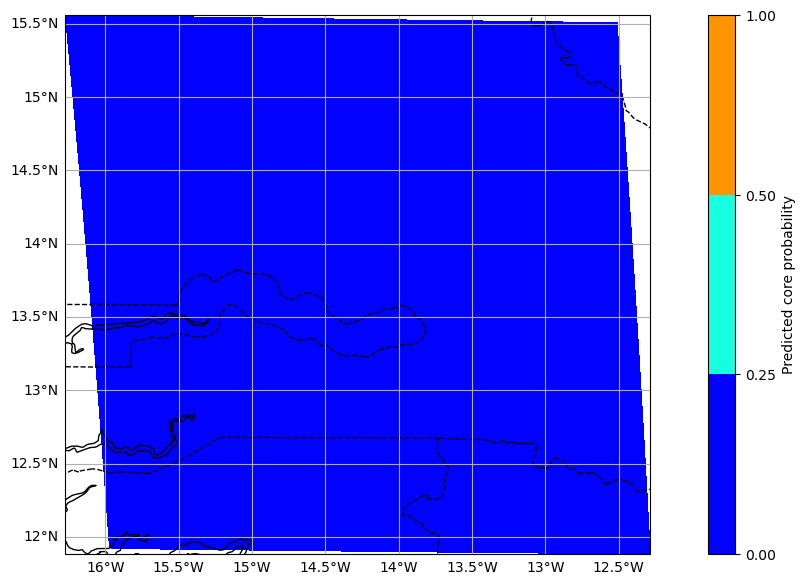

In [63]:
day = 24 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.25,0.5,1], cbar_label='Predicted core probability', cmap='jet')

#

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


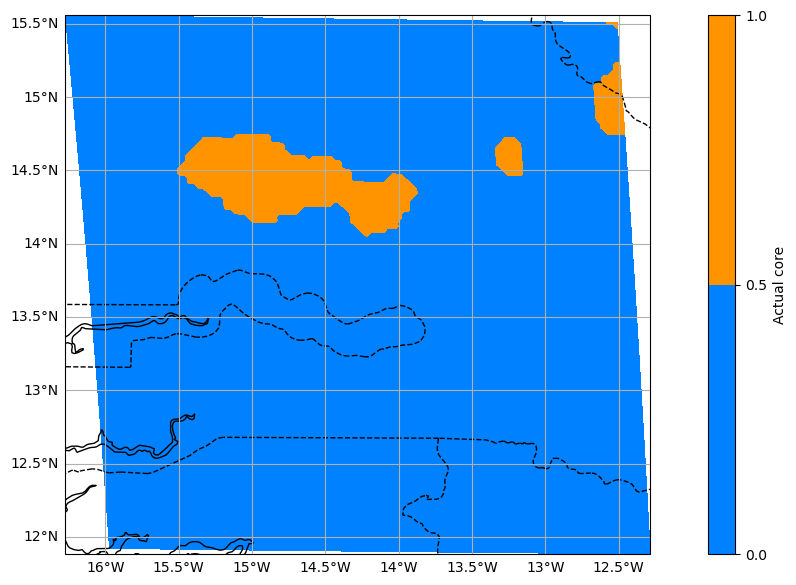

In [64]:
#day = 23 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(original_frames[0,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.5,1], cbar_label='Actual core', cmap='jet')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

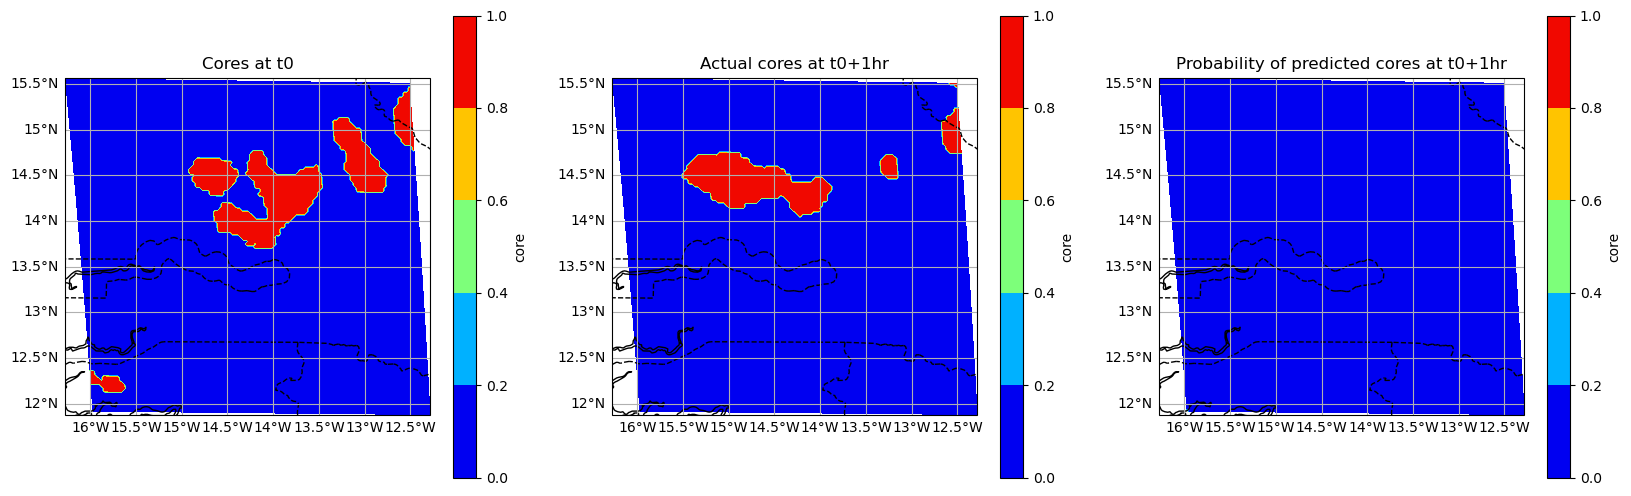

In [65]:
day = 23
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[day,:,:,0])
data[1] = np.squeeze(original_frames[0,:,:,0])
data[2] = np.squeeze(frames[day+1,:,:,0])
#titles = ['Cores at t0-1hr', 'Cores at t0', 'Probability of cores at t0+1hr']
titles = ['Cores at t0', 'Actual cores at t0+1hr', 'Probability of predicted cores at t0+1hr']


fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})
i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=[0, 0.2, 0.4, 0.6, 0.8,1],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()

In [30]:
# Construct a figure for the original and new frames.
#fig, axes = plt.subplots(2, 2, figsize=(20, 6))
# Plot the original frames.
#for idx, ax in enumerate(axes[0]):
#    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
#    ax.set_title(f"Actual core at t0+x{idx}")
#    ax.set_title(f"Frame {idx + 24}")
#    ax.axis("off")
    
# Plot the new frames.
#new_frames = frames[24:, ...]
#for idx, ax in enumerate(axes[1]):
#    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
#    ax.set_title(f"Predicted core at t0+x{idx}")
#    ax.axis("off")
    
# Plot the new frames.
#data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABkwAAAF0CAYAAABhfBUcAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAABPm0lEQVR4nO3deZQU5dk/7ntgNmRTFgUigitgjKiACpGIIBgxRMUdo0jUF2LUV42icQOMEZP4+jXGLUYQV9xYkrgTxRWMqGjEXUEQwQUUBcGBGZ7fH/6YOM6wNDLTA31d5/Q59tNPVd3dU87UzaerKi+llAIAAAAAACCH1cl2AQAAAAAAANkmMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwATZZV199deTl5cUuu+yy3uuYN29eDB8+PF5++eUNV9ga9OjRI3r06FEj26otXn/99Rg+fHi8//776zR/ypQpMXz48Fi0aFGVr7/00kux//77R4MGDWLzzTeP/v37x8yZMzdcwetoyZIlccYZZ0SrVq2iuLg4dtttt7jrrrtqvA4AAFgdPdPGYVPsmRYvXhxDhw6NPn36RPPmzSMvLy+GDx9eozUAVEVgAmyyRo8eHRERr732Wvz73/9er3XMmzcvRowYUWMH/7no9ddfjxEjRmR08D9ixIgqD/7ffPPN6NGjRyxfvjzuueeeGD16dLz99tvRvXv3+PTTTzds4WvRv3//uOWWW2LYsGHx0EMPRZcuXeKYY46JO++8s0brAACA1dEzbRw2xZ5p4cKFceONN0ZJSUkccsghNbZdgLURmACbpBdeeCFeeeWVOOiggyIiYtSoUVmuaOOydOnSbJewXi6++OIoKiqK+++/P/r27Rv9+/ePBx54ID799NO44oor1rjs8OHDo23bthukjgcffDAmTZoU1113XQwePDj222+/+Nvf/ha9e/eOc845J8rKyjbIdgAAYH3pmb4fPdP306ZNm/j888/jySefjJEjR26QdQJsCAITYJO06mD/8ssvj27dusVdd91V5QHthx9+GP/zP/8TrVu3jsLCwmjVqlUcfvjh8fHHH8cTTzwRXbp0iYiIQYMGRV5eXoXThFd3KvgJJ5xQ6SByxIgRsddee0WTJk2iUaNGsccee8SoUaMipbTe7/HOO++Mrl27RoMGDaJBgwax2267VWpyRo8eHR07dozi4uJo0qRJHHroofHGG29UqrdBgwbx6quvRp8+faJhw4bRq1eviIhYvnx5XHrppdG+ffsoKiqK5s2bx6BBg9bpm0cvvPBCHH300dG2bduoV69etG3bNo455piYPXt2+ZwxY8bEEUccERER++23X/lnPGbMmCrXOXz48DjnnHMiImLbbbctn//EE09EaWlp3H///XHYYYdFo0aNypdp06ZN7LfffjFhwoS1f6hrkFKKvn37RtOmTWPOnDnl40uXLo0f/vCH0aFDh/jqq68iImLChAnRoEGD8ve2yqBBg2LevHnr/e09AADYUPRM39AzZadnWlUXQG2Tn+0CADa0ZcuWxdixY6NLly6xyy67xC9/+cs46aST4t57742BAweWz/vwww+jS5cusWLFijj//PNj1113jYULF8YjjzwSn3/+eeyxxx5x8803x6BBg+LCCy8s/+bV1ltvnXFN77//fgwePDi22WabiIh47rnn4rTTTosPP/wwLr744ozXd/HFF8fvfve76N+/f/zmN7+Jxo0bx4wZMyocWI8cOTLOP//8OOaYY2LkyJGxcOHCGD58eHTt2jWmTZsWO+64Y/nc5cuXx89//vMYPHhwnHfeeVFaWhorV66Mgw8+OJ5++ukYOnRodOvWLWbPnh3Dhg2LHj16xAsvvBD16tVb43tu165dHH300dGkSZOYP39+XH/99dGlS5d4/fXXo1mzZnHQQQfFZZddFueff35ce+21sccee0RExPbbb1/lOk866aT47LPP4i9/+UuMHz8+WrZsGRERO++8c7z33nuxbNmy2HXXXSstt+uuu8akSZPi66+/juLi4ow/74hvDuhvu+222G233eLII4+Mp59+OgoKCuKUU06JWbNmxb///e+oX79+RETMmDEjOnToEPn5Ff/MrqptxowZ0a1bt/WqAwAAvi890zf0TP9V0z0TQK2VADYxt956a4qIdMMNN6SUUlq8eHFq0KBB6t69e4V5v/zlL1NBQUF6/fXXV7uuadOmpYhIN998c6XX9t1337TvvvtWGh84cGBq06bNatdZVlaWVqxYkS655JLUtGnTtHLlyrWu89tmzpyZ6tatm4499tjVzvn8889TvXr1Ut++fSuMz5kzJxUVFaUBAwZUqDci0ujRoyvMHTt2bIqING7cuArjqz6T6667bo11fldpaWlasmRJql+/fvrzn/9cPn7vvfemiEiTJ09ep/X86U9/ShGRZs2aVWH82WefTRGRxo4dW2mZyy67LEVEmjdvXvnYihUrKjwuuuii1KZNm0rj3/75pJTSM888k/Lz89MZZ5yRRo8enSIi3XTTTRXm7LjjjumAAw6oVMe8efNSRKTLLrtsnd4rAABUBz2Tnum7arpn+rZPP/00RUQaNmzYOr0/gOrkklzAJmfUqFFRr169OProoyMiyi+N9PTTT8c777xTPu+hhx6K/fbbLzp06FDtNT3++OOx//77R+PGjaNu3bpRUFAQF198cSxcuDA++eSTjNY1adKkKCsri1//+ternTN16tRYtmxZnHDCCRXGW7duHT179ozHHnus0jKHHXZYhef3339/bL755tGvX78oLS0tf+y2227RokWLeOKJJ9ZY55IlS+Lcc8+NHXbYIfLz8yM/Pz8aNGgQX331VaVT3DekNZ3W/e3XCgoKKjx+97vfxezZsyuN33LLLRXW8eMf/zh+//vfx1VXXRW/+tWv4he/+EWceOKJ610HAADUND2TnmldXqvungmgNhKYAJuUd999N5566qk46KCDIqUUixYtikWLFsXhhx8eEd9cn3aVTz/9dL1OFc/U888/H3369ImIiL/97W/x7LPPxrRp0+KCCy6IiG9Oh8/Eqmvhrqn2hQsXRkSUn379ba1atSp/fZXNNtuswjVsIyI+/vjjWLRoURQWFlY6IP7oo49iwYIFa6xzwIABcc0118RJJ50UjzzySDz//PMxbdq0aN68ecbveV00bdo0IqLSe4uI+OyzzyIvLy8233zz8rFp06ZVeJx88snRsmXLSuP9+vWrtL5jjz02CgsLo6SkpPz6wN+tZXV1REQ0adJkfd8mAAB8L3qmb+iZKqrpngmgtnIPE2CTMnr06EgpxX333Rf33XdfpddvueWWuPTSS6Nu3brRvHnzmDt37npvq7i4OL744otK4989KL7rrruioKAg7r///grXgp04ceJ6bbd58+YRETF37txo3bp1lXNWHQjPnz+/0mvz5s2LZs2aVRir6htGzZo1i6ZNm8bDDz9c5TYaNmy42hq/+OKLuP/++2PYsGFx3nnnlY+XlJSUhwYb2vbbbx/16tWLV199tdJrr776auywww4VPv/OnTtXmHP//fdHYWFhpfHvKisri2OPPTa22GKLKCoqihNPPDGeffbZKCwsLJ/zox/9KMaOHRulpaUV7mOyqrZddtllvd4jAAB8X3qmb+iZKqrpngmgtnKGCbDJKCsri1tuuSW23377mDx5cqXHb37zm5g/f3489NBDERFx4IEHxuTJk+Ott95a7TqLiooioupvNLVt2zbefvvtKCkpKR9buHBhTJkypcK8vLy8yM/Pj7p165aPLVu2LG677bb1ep99+vSJunXrxvXXX7/aOV27do169erF7bffXmF87ty58fjjj0evXr3Wup2f/exnsXDhwigrK4vOnTtXerRr1261y+bl5UVKqfzzW+Wmm26KsrKyCmNr+oyrsrr5+fn50a9fvxg/fnwsXry4fHzOnDkxefLk6N+//zqtf22GDRsWTz/9dNxxxx1x9913xyuvvFLpG1OHHnpoLFmyJMaNG1dh/JZbbolWrVrFXnvttUFqAQCATOiZ/kvPlN2eCaDWyuYNVAA2pH/+858pItIf/vCHKl//9NNPU1FRUTrkkENSSinNnTs3tWzZMm255ZbpqquuSo899lgaN25cOvnkk9Mbb7yRUkrpq6++SvXq1Us//vGP0+TJk9O0adPShx9+mFL65kZ2EZEOP/zw9Mgjj6Q777wz7bbbbqlNmzYVbmD42GOPlc979NFH09ixY1OnTp3SjjvuWOlGfOtyA8OUUrrooovK1zlu3Lj0r3/9K1199dXp4osvLp+z6qZ9xx13XHrwwQfTbbfdlnbYYYfUuHHj9Pbbb5fPGzhwYKpfv36lbZSWlqYDDzwwNWnSJI0YMSI99NBD6V//+lcaM2ZMGjhwYBo/fvwaa/zJT36SmjRpkv72t7+lSZMmpQsvvDC1bNkybb755mngwIHl82bOnJkiIh1yyCHp6aefTtOmTUsLFixY7XonT56cIiINHjw4TZkyJU2bNi19+eWXKaWU3njjjdSgQYP0k5/8JD344INp/PjxaZdddkmtWrVKn3zyyRrrHTZs2BpvPJlSSo8++miqU6dOhZsRXnHFFSkiKn0evXv3TltssUW68cYb0+OPP55OPvnkFBHp9ttvX+M2AACguuiZ9Ey1qWd68MEH07333lt+Y/gjjjgi3Xvvvenee+9NX3311Rq3A1BdBCbAJuOQQw5JhYWFazzIO/roo1N+fn766KOPUkopffDBB+mXv/xlatGiRSooKEitWrVKRx55ZPr444/Llxk7dmxq3759KigoSBFR4cDvlltuSR06dEjFxcVp5513TnfffXcaOHBgpYPI0aNHp3bt2qWioqK03XbbpZEjR6ZRo0at98F/SindeuutqUuXLqm4uDg1aNAg7b777unmm2+uMOemm25Ku+66ayosLEyNGzdOBx98cHrttdcqzFndwX9KKa1YsSJdccUVqWPHjuXbad++fRo8eHB655131ljf3Llz02GHHZa22GKL1LBhw/TTn/40zZgxI7Vp06bCwX9KKV111VVp2223TXXr1k0RUel9fNdvf/vb1KpVq1SnTp0UEWny5Mnlr73wwgupV69eabPNNkuNGjVKhxxySHr33XfXuL6U1n7wP2/evLTlllumnj17prKysvLxlStXpn79+qXNN9+8ws9y8eLF6fTTT08tWrRIhYWFadddd01jx45dax0AAFBd9Ex6ppRqT8/Upk2bFBFVPr49D6Am5aWUUnWfxQIAAAAAAFCbuYcJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAJQg/Ly8jaKR48ePWLevHlrfC8lJSXxv//7v+u0vm233Tb69u0bnTt3rrH3AAAAbHyqu09o06ZNpW3usMMO1dIz/ehHP8p6b6dnAshMfrYLAKBmFBYWxh//+MeoW7du+VhJSUmce+65UVZWVmHukiVLYsmSJWtc34gRI+Lqq69ep20feuihceWVV8b7778fxx13XDzzzDOZvwEAAIBa4sknn4zHH388fvGLX2S7FAA2IIEJQI7Iz8+PIUOGRFFRUfnYkiVL4uabb47S0tIKc3/yk5/ETjvttMb1/fOf/1yn7e6zzz5x0UUXRURE27ZtY+LEiXHwwQfHggULYs6cObFs2bIM3wkAAMD6WbFiRXz88cex1VZbfe91zZ8/P8rKyip8KQ2AjZvABCCHNWjQIGbMmFGt27j11ltjiy22KH/etGnT8jNMunfv7mwTAACgxsyfPz8OOeSQuOOOO2K77bb7XuuaPHly/OpXv4oGDRpsoOoAyDaBCQDV5rTTTouWLVuu9vWRI0dGv379YsmSJZXOcgEAAKgOzz33XLz44ovRvHnzuOmmmyrci6Ru3bqx2WabrdN6jj/++A0SltSvXz/q1KkTv/vd72Lx4sXlZ+gDUPMEJgBUmx133DGKi4tX+/o+++wTH3/8cZx88slx66231mBlAABALhswYEDUqVMnSktLY+XKlRHxTVhy0UUXxW9/+9t1Wkd+/ob5Z7VrrrkmBgwYEAUFBet86WMAqkedbBcAwMbl3XffjZNPPjk+/PDDDbK+wsJC1/wFAABqVGlpaSxfvrw8LImIOOuss+LCCy+MwsLCdXrUqVP1P6tl2jP9/ve/j8LCwsjLy9sg7w2A9ecME4AcsXLlypg9e/Zab+a+JrNmzYrevXvH+++/v9a5PXr0iEGDBq33tgAAAGrKwQcfHEcdddRqQ5B1lUnP9O1lfvCDH0RExNdff/29tg/A9+MME4Ac8fXXX8fPf/7zmD59+nqv47zzzlvnA/+ioiI3PwQAADYKf//73+MnP/lJLF++/HutJ5OeaZWysrKYN29ezJs3Lz777LPvtX0Avh+BCUAOeeutt+Lwww+Pt99+O5YtW5bRssuXL8+oeVi+fHksWrSowinuERFLly6NRYsWVXj4FhUAAAAA2eaSXAA5ZubMmbHzzjvH2WefHZdffvk6L3f33XfH3//+93We/8QTT0SzZs3iqquuii233LJ8fNSoUfHYY49VmPvdUAUAAAAAaprABCAHlZWVRVlZWUbLrFy5MlJK6zw/pRRlZWVx2mmnZVoeAABAjVu+fHmcdNJJMWjQoOjZs+d6rSOTngmA2scluQBy1HXXXRe33XabA3oAAICIKC0tjdtvvz3eeuut9Vr+nnvuiX/84x8buCoAapLABCBHLV26NE499dQoLS1d69wlS5ZkdDkuAACAjdUDDzwQ1113XcbLLVu2LEpKSqqhIgBqisAEIIctWbIkLrjggrXOW7p0aUycOLH6CwIAAMiyBx54IP7yl79kuwwAskBgApDDVq5cGe+++262ywAAAKhVvvzyy3jppZeyXQYANUxgAlCD6tSpfb92p02bFgMGDIhFixZV+fq9994bgwcPdq8TAAAgZ8ybNy/uuuuubJcBQA2rff9yB7AJe/jhh2PvvfeOoqKibJdSbu7cuTF27NhYtmxZpdemT58exx9/vMtxAQAAALDJy892AQC5pHfv3tG7d+8YMWJEDB8+PNvlVDBy5Mho0KBBhbH58+fH119/naWKAAAAsuepp56KSy65JC688MJaebUAADa8vOQaKwA1rqSkJC677LK4/PLLY/ny5dkuZ5PkzxsAAGx88vLysl1CBQ0aNIj33nsvttxyyzXOW7BgQXzyySfxq1/9Kp566qkaqu770TMBVCYeB8iCoqKiGDFiRAwbNsw3lQAAAGqpJUuWRN++fePtt99e7Zzp06dH586d44c//OFGE5YAUDX/SgeQRUOHDo1zzz0322UAAACwGi+++GIMGDAgPv3000qvvfXWWzFgwICYPXt2FioDYENzDxOALMrPz48999wz22UAAACwBi+++GL07NkzrrnmmvKxlFIMGDAg5s+fn8XKANiQBCYArLc999wzDj/88Hjvvffir3/9a7bLAQAAqDYzZsyIHj16ZLsMAKqRS3IBZNH7778fZ555ZrbLWG8dO3aMc845J6688sp4/fXXo23bttkuCQAA2Ihts8020aBBg2yXsUHUrVs3Bg8eHK+//nr5Q88EULsJTACy5JVXXokDDjgg3n///WyX8r1tttlm0aFDhygqKsp2KQAAwEZs9uzZMXDgwGyX8b3ttddeMXTo0LjhhhuiQ4cO5Y/DDjss26UBsAYCE4AaVFJSEiUlJTFz5sw4+uij4+233852SQAAAGxgBx98cFx22WWVxk877bTIz3eFfIDaym9ogBrUpEmTiPjm5oDLli3LcjXf39y5c+PTTz+N5s2bR0REt27dIi8vL4qLi8vHqvLUU09FSUlJTZUJAABsJCZNmhQffPBBtsv43t55551YsmRJpcuLffDBB/HLX/4ybrzxxixVBsCa5KWUUraLAMgVeXl5Gc295JJLolGjRhXG33///fh//+//bejS1tuECRPikEMOKX/+n//8Jxo3bhxt2rRZ7TKtW7eOuXPnVmtd/rwBAMDGJ5Oe6dhjj40999yzwtgtt9wSL7300oYua7386le/iuuuu67CWPv27eOtt97KUkUV6ZkAKhOYANSgdTn4v+eee6JTp04REdGmTZuoW7duhddLSkriww8/jIMOOijefPPNaqkzE98NTNbF008/HYceemgsXLiweooKB/8AALAxWlvPNGTIkDjnnHMiImLLLbesdAbH/Pnzo2fPnrWiV9pqq63iP//5T2y55ZblYwcccEBMnz49Pv300/KxNm3aREFBQVx++eWx++67R8Q393I54ogj9EwANcw9TABqkc6dO0fnzp1ju+22i+22265SWBIRUVRUFNttt10MGjQo9t9//yxU+f1179497r777mjVqlW2SwEAADYSTZs2jYMOOqi8X/puWBIR0bJly3jooYeic+fOWaiwoo8//jgOPvjgmDlzZvnYI488EuPHj4+2bduWj02ePDneeeedOOyww8rf23777adnAsgCgQlALdG2bdsYO3ZsbLvttus0f+jQofGLX/yiylBlY9CrV6/Ybrvtsl0GAACwkWjZsmX87Gc/W+u8Vb3VzjvvHIWFhTVQWdXy8vKiRYsW0bBhwwrj++yzT4wfPz4effTRePTRR6NFixZVLq9nAqh5AhOAWqJBgwaxww47ZLTML37xi3VqGGqrLl26ZHSNYgAAIDftsssuse+++67z/B122CGmT58ef/7zn6uxqjVr2bJl3HPPPdG8efNKr+2+++7Ru3fv6N27d9SrV2+169AzAdQsgQnARqxu3brxP//zP1FcXJztUtbL5ZdfHieffHK2ywAAAGq5008/Pa655pqMliksLIyCgoJqqmjtTjvttO+9/WHDhm20VxUA2BgJTABqgZYtW8bYsWPXa9nevXtn9TTz76OwsDB69+6d7TIAAAA2uI35agAAuUpgAlALjBgxInbZZZdslwEAAMAGsM8++0SzZs2yXQYAGRKYAGRZfn5+3HjjjfHZZ59lvOyKFSviyy+/jJRSNVS2dj/72c+ie/fuWdk2AACQG/Lz8ze6s+r79u272pu5A1B7CUwAsqxv374xZcqUaNKkSUbLff3113HWWWdFy5YtY/HixdVU3Zq1bNkymjZt+r3W8YMf/CDatGmzgSoCAAA2NX379o3jjjsu22UAkAMEJgBZVqdOnfW6EeCwYcPimmuuiRUrVlRDVTWna9eu0bNnz2yXAQAA1ELFxcVxyimnRJ066/dPWN27d4899thjA1cFwKZKYAKwkXr44YezXcJazZs3L5YvX57tMgAAgI3Q4MGDY9asWXHAAQes1/KlpaXx9ddfxxZbbLGBK6s5devWjV133XWjfg8AGxOBCUAWFRYWRv/+/dd5/oQJE+LSSy+NSy+9ND755JNqrOz7mzlzZhx22GHxxz/+ca1zf/azn0X9+vVroCoAAGBjMWPGjCgpKVmvZZ944om44IILomPHjvHYY49t4MpqToMGDeLFF1+MQw45JNulAOSE/GwXAJDLioqK4qijjlrrvJRSjBs3LoYMGRILFy6sgcrWzddffx2fffZZpfuvLFy4MPr37x+vvPJKvPzyy3H//ffHyJEjY7/99qtyPYceemg0aNAgvvrqq5ooGwAA2Ag8++yzMXPmzIzveTh16tQ49thjY968edVU2dpdf/31ceCBB8Zuu+221rmLFi2KlStXRkREQUFBNGzYsJqrA2B1nGECUMvNmDEj/va3v8XRRx9dq8KSiIjbb789tt5661iyZEmF8YEDB8Yrr7wSEd+EKv/+97/jkEMOWe3lufLy8qJHjx7VXS4AALCJKysri5///OdZDUsiIj744IPo3bt3PP/882ud26VLl9hyyy1jyy23jOOPP74GqgNgdZxhAlDLjRs3LoYPH57tMqqUUoqSkpI4+eSTIz//v39Spk+fXmnu0qVL4y9/+Uv85je/qXJd119/fZSWlsa4ceOqrV4AAGDTtXLlyrj++uvjyy+/zHYpERGxYMGC+Nvf/hadO3eu9NqKFSvi17/+dZSUlMRHH30UZWVlERHlZ5oAkB0CE4BabOnSpVn/ZtTarFy5Mu666661zistLY2JEyfG8ccfH82bN6/0+hZbbBEdO3YUmAAAABl77rnn4uCDD44vvvhitWe2Z8Ptt98eEydOrPK1BQsWVBr77LPP4tNPP63UM/35z3+Ot99+O5599tnqKBOA/59LcgFkUUlJSdxzzz2rff3NN9+MG2+8sQYrql7PPPNMjB8/PttlAAAAm5jTTjstPvnkk/W+SXx1+frrr2PBggVVPqqyup6pYcOGcc0111R3uQA5T2ACkEXNmjWLLl26ZLuMGrV48eIqTzMvLS1103cAACAjpaWl8cknn0RpaWm2S9lgVtcztWvXLoYMGZKFigByh8AEIItuu+22aNeuXbbLqFFDhw6Nq6++Ol566aUK4zNmzIg//OEPWaoKAADYGP3nP/+JFi1axMsvv5ztUjaYoUOHVnlp5mXLlsXHH3+chYoAcofABCBL8vLyok6dtf8azsvLq4Fqak5KKc4888w49thjY8aMGVFWVlb+AAAAWCUvL2+d+qGUUg1UU3NSSvH73/++0lkms2bNigkTJmSpKoDcIDAByJJTTjkl9tlnnzXO6dixY5x77rk1VFHNevPNN6Nr167RrFmzaNasWey3337ZLgkAAKhF1qVnql+/frRu3bqGKqo5N954YwwePDi+/PLLiPgmRDnqqKOyXBXApi8/2wUA5KJmzZpF//79Iz9/zb+G69atG8XFxTVUVc1bsmRJtksAAABqqeLi4rX2TO3atYsTTzwxhg8fXjNF1ZCVK1fGTTfdFF9//XW0bt06Ukrx0UcfZbssgE2ewAQgC5o2bRo9e/bMdhkAAAC1Un5+fjRu3Hit8+bPnx9ffPFFDVSUHbfffnu2SwDIKQITAAAAAGqV7bffPi666KI1zkkpxW677RaffPJJDVUFwKbOPUwAarGUkpuhAwAAOWdtvdDKlSvjqquu2qTPLgGg5glMAGqx2267Lf7whz9kuwwAAIAa9e6778agQYPi6aefjpRShddKS0vjsssui6FDh0ZJSUmWKgRgU5SXvvtXB4Bqk5eXFxHf3JjwzTffXOPclFK0aNHC6eXryZ83AADY+KzqmVZp2LBhLFiwIAoLC8vHFi1aFM2aNXM2/vekZwKozD1MALJg1qxZ0b59+/jTn/4U/fr1q/T60qVLY+jQobFw4cIsVAcAAFA7fPXVV/GjH/2oQpBSVlYmLAGgWjjDBKAGfffbUkVFRfHHP/4x9t9//9h5553Lx++555446qijarq8TYo/bwAAsPH5bs9E9dEzAVQmMAGoQas7+N9ll12idevW5c/nz58fL7/8cg1VtWny5w0AADY+ApOao2cCqExgAlCDHPzXHH/eAABg46Nnqjl6JoDK6mS7AAAAAAAAgGwTmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5jAJmzMmDGRl5dX/sjPz4+tt946Bg0aFB9++GGN1NC2bds44YQTyp8/8cQTkZeXF0888URG65kyZUoMHz48Fi1atEHri4g44YQTom3btht8vWRfVfvbgw8+GMOHD89aTZlu/84774yrrrpqta/fddddsdtuu0VxcXG0atUqzjjjjFiyZMn3LzRDM2fOjP79+8fmm28eDRo0iN69e8dLL71U43UAAGRK37Ru9E2bLn1TzXjttdfilFNOia5du0b9+vXX6/9xoPoJTCAH3HzzzTF16tSYNGlSnHzyyTF27Njo3r17fPXVVzVeyx577BFTp06NPfbYI6PlpkyZEiNGjKiWA382XVXtbw8++GCMGDEiazVluv01Hfjfcccdccwxx0SXLl3ioYceimHDhsWYMWOif//+G6jadfPpp59G9+7d4+23347Ro0fHPffcE19//XX06NEj3nrrrRqtBQBgfembyFX6pprxwgsvxMSJE6NJkybRq1evGt02sO4EJpADdtlll9h7771jv/32i2HDhsXQoUNj1qxZMXHixNUus3Tp0mqppVGjRrH33ntHo0aNqmX9tV1KabWPr776ao2vV/dj5cqVsXTp0nWef/PNN0dExLRp0zZYDcOGDYuIb/4Bfn2Wj4gYNmxY+X9vyvtbWVlZnHPOOdGnT5/429/+Fvvtt18MHjw4rrvuupg0aVI89NBDa1y+R48eFb7F+H386U9/ik8//TQeeOCB6N+/f/Tt2zceeOCBKCoqiosvvniDbAMAoLrpm2qHtR3z65s2XN+0yqa8v9Wmvum4446LefPmxQMPPBDHH3/8BlknsOEJTCAH7b333hERMXv27Ij45tTqBg0axKuvvhp9+vSJhg0bln/bYfny5XHppZdG+/bto6ioKJo3bx6DBg2KTz/9tMI6V6xYEUOHDo0WLVrEZpttFvvss088//zzlba9ulPL//3vf0e/fv2iadOmUVxcHNtvv32cccYZERExfPjwOOeccyIiYtttty0/Vf7b67j77rvLT2tt0KBBHHDAATF9+vRK2x8zZky0a9cuioqKokOHDnHrrbdm9Nndeeed0bVr12jQoEE0aNAgdttttxg1alSFOaNHj46OHTtGcXFxNGnSJA499NB44403KszZEJ95VVat97XXXotevXpF/fr1o3nz5nHqqadWauby8vLi1FNPjRtuuCE6dOgQRUVFccstt0RExDPPPBO9evWKhg0bxmabbRbdunWLBx54oMptfv755zFo0KBo0qRJ1K9fP/r16xczZ86sMGfSpElx8MEHx9Zbbx3FxcWxww47xODBg2PBggVVrvODDz6I/v37R6NGjaJx48bxi1/8otL779GjR/To0WONn8d397cTTjghrr322vL3v+rx/vvvR69evaJ9+/blDcQqKaXYYYcd4qCDDlrjtu6+++7o06dPtGzZMurVqxcdOnSI8847r8I3Ete0/ar06NEjHnjggZg9e3aF+RERzz33XMyfPz8GDRpUYZkjjjgiGjRoEBMmTFhjvWuzYMGCaN26dXTr1i1WrFhRPv76669H/fr147jjjisfmzBhQvTs2TPatGlTPtaoUaPo379//POf/4zS0tLvVQsAQDbom/RNEfomfdOaZdI31anjn2FhY+D/VMhB7777bkRENG/evHxs+fLl8fOf/zx69uwZf//732PEiBGxcuXKOPjgg+Pyyy+PAQMGxAMPPBCXX355TJo0KXr06BHLli0rX/7kk0+OK664Io4//vj4+9//Hocddlj0798/Pv/887XW88gjj0T37t1jzpw5ceWVV8ZDDz0UF154YXz88ccREXHSSSfFaaedFhER48ePj6lTp1Y4Xfiyyy6LY445Jnbeeee455574rbbbovFixdH9+7d4/XXXy/fzpgxY2LQoEHRoUOHGDduXFx44YXxu9/9Lh5//PF1+twuvvjiOPbYY6NVq1YxZsyYmDBhQgwcOLC8gYqIGDlyZJx44onxwx/+MMaPHx9//vOf4z//+U907do13nnnnQrr+76f+eqsWLEi+vbtG7169YqJEyfGqaeeGn/961/jqKOOqjR34sSJcf3118fFF19c/nN48skno2fPnvHFF1/EqFGjYuzYsdGwYcPo169f3H333ZXWceKJJ0adOnXKT4F+/vnno0ePHhUuA/Dee+9F165d4/rrr49HH300Lr744vj3v/8d++yzT4WDylUOPfTQ2GGHHeK+++6L4cOHx8SJE+OAAw6ocm4mLrroojj88MMjIsr3o6lTp0bLli3jf//3f+Ott96Kxx57rMIyDz30ULz33nvx61//eo3rfuedd6Jv374xatSoePjhh+OMM86Ie+65J/r167dO26/KddddFz/+8Y+jRYsWFeZHRMyYMSMiInbdddcKyxQUFET79u3LX19fzZo1i7vuuiumTZsW5557bkR88w3KI444IrbZZpu44YYbIiJi2bJl8d5771WqY1Vty5Ytq9QIAgBsDPRN+qZV9E36ptVZ174J2IgkYJN18803p4hIzz33XFqxYkVavHhxuv/++1Pz5s1Tw4YN00cffZRSSmngwIEpItLo0aMrLD927NgUEWncuHEVxqdNm5YiIl133XUppZTeeOONFBHpzDPPrDDvjjvuSBGRBg4cWD42efLkFBFp8uTJ5WPbb7992n777dOyZctW+17+9Kc/pYhIs2bNqjA+Z86clJ+fn0477bQK44sXL04tWrRIRx55ZEoppbKystSqVau0xx57pJUrV5bPe//991NBQUFq06bNaredUkozZ85MdevWTccee+xq53z++eepXr16qW/fvpVqLCoqSgMGDCgf+76f+eqsWu+f//znCuO///3vU0SkZ555pnwsIlLjxo3TZ599VmHu3nvvnbbccsu0ePHi8rHS0tK0yy67pK233rr881u1fx166KEVln/22WdTRKRLL720yhpXrlyZVqxYkWbPnp0iIv39738vf23YsGFr3Jduv/328rF999037bvvvhXmRUQaNmxY+fOq9rdf//rXqao/f2VlZWm77bZLBx98cIXxAw88MG2//fYV9pu1WfUen3zyyRQR6ZVXXlnr9lfnoIMOqnL/XPUznT9/fqXX+vTpk3baaadK9Xz78ZOf/CQdf/zxlca/6w9/+EOKiDRhwoQ0cODAVK9evfSf//yn/PUPP/wwRUQaOXJkpWXvvPPOFBFpypQp6/x+AQBqmr5J37SKvmly+Zi+acP2Td917733VvrMgdrBGSaQA/bee+8oKCiIhg0bxs9+9rNo0aJFPPTQQ7HVVltVmHfYYYdVeH7//ffH5ptvHv369YvS0tLyx2677RYtWrQoP1138uTJERFx7LHHVlj+yCOPjPz8/DXW9vbbb8d7770XJ554YhQXF2f83h555JEoLS2N448/vkKNxcXFse+++5bX+NZbb8W8efNiwIAB5afmRkS0adMmunXrttbtTJo0KcrKytb4bZmpU6fGsmXLKl3ftHXr1tGzZ89K38CJWP/PfG2++7MYMGBARPz3Z7VKz549Y4sttih//tVXX8W///3vOPzww6NBgwbl43Xr1o3jjjsu5s6dW+km3t/dVrdu3aJNmzYVtvXJJ5/EkCFDonXr1pGfnx8FBQXll2/67mn3Va1z1b703fo3pDp16sSpp54a999/f8yZMycivvmG18MPPxynnHJKhf2mKjNnzowBAwZEixYtom7dulFQUBD77rtvRFT9HjeU1dX17fEnn3wyCgoKKjyeeuqpuPXWWyuNf/c093POOScOOuigOOaYY+KWW26Jv/zlL/GjH/1onetY22sAALWFvknfpG9aO33T9+ubgNpvzX+RgU3CrbfeGh06dIj8/PzYaqutqjyNdbPNNqt0g7ePP/44Fi1aFIWFhVWud9V1VBcuXBgRES1atKjwen5+fjRt2nSNta26vurWW2+9bm/mO1adft6lS5cqX191jdDV1bhqbHXXQs2kzlXbqOrzbdWqVUyaNKnC2Pf5zNekqs991fteVeMq3631888/j5TSat9DVetY3We6at7KlSujT58+MW/evLjoooviRz/6UdSvXz9WrlwZe++9d5Wny69uX/rutje0X/7yl3HxxRfHDTfcEJdddllce+21Ua9evfjlL3+5xuWWLFkS3bt3j+Li4rj00ktjp512is0226z8msLrckmATK36GS9cuLBSE//ZZ59FkyZNyp936tQppk2bVmHO4MGDo1WrVhVu9hjx35/zKnl5eXHCCSfEAw88EC1atKhwDd6IiC222CLy8vKq/Nl89tlnEREVagEAqK30TfomfdO60Tdl3jcBGw+BCeSADh06ROfOndc4p6pvWzRr1iyaNm0aDz/8cJXLNGzYMCL+ewDy0UcfxQ9+8IPy10tLS9d6oLbqesBz585d47zVadasWURE3HfffRVuOP1d367xu6oa+65v19m6des1bmP+/PmVXps3b155rat8n898TVZ97t8++F/1Hr/bEHy3hi222CLq1Kmz2vewqsZvW91nusMOO0TEN9eMfeWVV2LMmDExcODA8jmrrgldldXtS2trJL+vxo0bx8CBA+Omm26Ks88+O26++eYYMGBAbL755mtc7vHHH4958+bFE088Uf7tqIiocD3iDW3Vt5VeffXV2HnnncvHS0tL480334xjjjmmfKxhw4aVfgc0bNgwmjZtutbfDfPnz49f//rXsdtuu8Vrr70WZ599dlx99dXlr9erVy922GGHePXVVyst++qrr0a9evViu+22W6/3CABQk/RN+iZ907rRN1W2tr4J2Hi4JBewWj/72c9i4cKFUVZWFp07d670aNeuXURE9OjRIyIi7rjjjgrL33PPPVFaWrrGbey0006x/fbbx+jRo6OkpGS184qKiiIiKn3j5IADDoj8/Px47733qqxx1UFNu3btomXLljF27NhIKZUvP3v27JgyZcpaP4s+ffpE3bp14/rrr1/tnK5du0a9evXi9ttvrzA+d+7cePzxx6NXr15r3c66fuZr892fxZ133hkR//1ZrU79+vVjr732ivHjx1f4rFeuXBm33357bL311rHTTjutcVtTpkyJ2bNnl29rVXOx6me4yl//+td1rn/VvrS2+tfF6valVU4//fRYsGBBHH744bFo0aI49dRT17rOTN7j2rZf1fyq5u61117RsmXLGDNmTIXx++67L5YsWRL9+/dfp/WvSVlZWRxzzDGRl5cXDz30UIwcOTL+8pe/xPjx4yvMO/TQQ+Pxxx+PDz74oHxs8eLFMX78+Pj5z3++1ktMAABszPRN/6Vv0jetSa73TcDGwb9gAKt19NFHxx133BF9+/aN//3f/40999wzCgoKYu7cuTF58uQ4+OCD49BDD40OHTrEL37xi7jqqquioKAg9t9//5gxY0ZcccUVlU6drsq1114b/fr1i7333jvOPPPM2GabbWLOnDnxyCOPlB8ArvpWyJ///OcYOHBgFBQURLt27aJt27ZxySWXxAUXXBAzZ86Mn/70p7HFFlvExx9/HM8//3zUr18/RowYEXXq1Inf/e53cdJJJ8Whhx4aJ598cixatCiGDx9e5anR39W2bds4//zz43e/+10sW7YsjjnmmGjcuHG8/vrrsWDBghgxYkRsvvnmcdFFF8X5558fxx9/fBxzzDGxcOHCGDFiRBQXF1c6hff7fOZrUlhYGP/3f/8XS5YsiS5dusSUKVPi0ksvjQMPPDD22WeftdYwcuTI6N27d+y3335x9tlnR2FhYVx33XUxY8aMGDt2bKVvV73wwgtx0kknxRFHHBEffPBBXHDBBfGDH/wgTjnllIiIaN++fWy//fZx3nnnRUopmjRpEv/85z8rnWr/bePHj4/8/Pzo3bt3vPbaa3HRRRdFx44d48gjj1xr/Wuzal/6wx/+EAceeGDUrVs3dt111/LT+Xfaaaf46U9/Gg899FDss88+0bFjx7Wus1u3brHFFlvEkCFDYtiwYVFQUBB33HFHvPLKKxlvv6r548ePj+uvvz46deoUderUic6dO0fdunXjj3/8Yxx33HExePDgOOaYY+Kdd96JoUOHRu/eveOnP/3p+n5E5YYNGxZPP/10PProo9GiRYv4zW9+E08++WSceOKJsfvuu8e2224bERFnn3123HbbbXHQQQfFJZdcEkVFRXH55ZfH119/HcOHD//edQAA1Gb6pv/SN+mb1iTX+6alS5fGgw8+GBERzz33XER8c9+UBQsWRP369ePAAw/83rUAG0A27zgPVK+bb745RUSaNm3aGucNHDgw1a9fv8rXVqxYka644orUsWPHVFxcnBo0aJDat2+fBg8enN55553yeSUlJek3v/lN2nLLLVNxcXHae++909SpU1ObNm3SwIEDy+dNnjw5RUSaPHlyhe1MnTo1HXjggalx48apqKgobb/99unMM8+sMOe3v/1tatWqVapTp06ldUycODHtt99+qVGjRqmoqCi1adMmHX744elf//pXhXXcdNNNaccdd0yFhYVpp512SqNHj04DBw5Mbdq0WeNntMqtt96aunTpUv5Z7L777unmm2+utI1dd901FRYWpsaNG6eDDz44vfbaaxXmbIjPvCqr1vuf//wn9ejRI9WrVy81adIk/epXv0pLliypMDci0q9//esq1/P000+nnj17pvr166d69eqlvffeO/3zn/+sMGfV/vXoo4+m4447Lm2++eapXr16qW/fvpXqfP3111Pv3r1Tw4YN0xZbbJGOOOKINGfOnBQRadiwYeXzhg0bliIivfjii6lfv36pQYMGqWHDhumYY45JH3/8cYV17rvvvmnfffet9J6+vb6q9reSkpJ00kknpebNm6e8vLwUEWnWrFkV1jNmzJgUEemuu+6q8vOpypQpU1LXrl3TZpttlpo3b55OOumk9NJLL6WIqLCPrMv2v+2zzz5Lhx9+eNp8883L53/bnXfeWb6/tWjRIp1++ulp8eLFa6133333rfD/5nc9+uijqU6dOhU+z5RSWrhwYdpmm21Sly5dUklJSfn4u+++mw455JDUqFGjtNlmm6VevXqlF198ca11AABkm75J36Rv0jetzobsm2bNmpUiosrHuv6/BVS/vJS+dY4lABu1E044ofzUYtbfYYcdFs8991y8//77UVBQkO1yAACADUjftGHom4BNkUtyAUBElJSUxEsvvRTPP/98TJgwIa688koH/QAAAN+ibwI2dQITAIiI+fPnR7du3aJRo0YxePDgOO2007JdEgAAQK2ibwI2dS7JBQAAAAAA5Lw62S4AAAAAAAAg2wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5Lz8bBcAkEvy8vKyXULOSClluwQAACBDeqaao2cCqMwZJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOU9gAgAAAAAA5DyBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5Ly+llLJdBAAAAAAAQDY5wwQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHJexoHJU089Ff369YtWrVpFXl5eTJw4ca3LPPnkk9GpU6coLi6O7bbbLm644Yb1qRUAAKDW0zMBAMDGKePA5KuvvoqOHTvGNddcs07zZ82aFX379o3u3bvH9OnT4/zzz4/TTz89xo0bl3GxAAAAtZ2eCQAANk55KaW03gvn5cWECRPikEMOWe2cc889N/7xj3/EG2+8UT42ZMiQeOWVV2Lq1Knru2kAAIBaT88EAAAbj2q/h8nUqVOjT58+FcYOOOCAeOGFF2LFihXVvXkAAIBaTc8EAAC1Q351b+Cjjz6KrbbaqsLYVlttFaWlpbFgwYJo2bJlpWVKSkqipKSk/PnKlSvjs88+i6ZNm0ZeXl51lwwAAFmVUorFixdHq1atok6dav+OE1mmZwIAgMxVR99U7YFJRFQ6YF91FbDVHciPHDkyRowYUe11AQBAbfbBBx/E1ltvne0yqAF6JgAAWD8bsm+q9sCkRYsW8dFHH1UY++STTyI/Pz+aNm1a5TK//e1v46yzzip//sUXX8Q222wTH3zwQTRq1Kha6wUAgGz78ssvo3Xr1tGwYcNsl0IN0DMBAEDmqqNvqvbApGvXrvHPf/6zwtijjz4anTt3joKCgiqXKSoqiqKiokrjjRo1cvAPAEDOcGml3KBnAgCA9bch+6aML+y1ZMmSePnll+Pll1+OiIhZs2bFyy+/HHPmzImIb77pdPzxx5fPHzJkSMyePTvOOuuseOONN2L06NExatSoOPvsszfMOwAAAKhF9EwAALBxyvgMkxdeeCH222+/8uerTgMfOHBgjBkzJubPn1/eCEREbLvttvHggw/GmWeeGddee220atUqrr766jjssMM2QPkAAAC1i54JAAA2Tnlp1d0Ea7Evv/wyGjduHF988YXTywEA2OQ5/iVT9hkAAHJNdRwDZ3xJLgAAAAAAgE2NwAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOetV2By3XXXxbbbbhvFxcXRqVOnePrpp1c794knnoi8vLxKjzfffHO9iwYAAKjN9EwAALDxyTgwufvuu+OMM86ICy64IKZPnx7du3ePAw88MObMmbPG5d56662YP39++WPHHXdc76IBAABqKz0TAABsnDIOTK688so48cQT46STTooOHTrEVVddFa1bt47rr79+jcttueWW0aJFi/JH3bp117toAACA2krPBAAAG6eMApPly5fHiy++GH369Kkw3qdPn5gyZcoal919992jZcuW0atXr5g8efIa55aUlMSXX35Z4QEAAFDb6ZkAAGDjlVFgsmDBgigrK4utttqqwvhWW20VH330UZXLtGzZMm688cYYN25cjB8/Ptq1axe9evWKp556arXbGTlyZDRu3Lj80bp160zKBAAAyAo9EwAAbLzy12ehvLy8Cs9TSpXGVmnXrl20a9eu/HnXrl3jgw8+iCuuuCJ+8pOfVLnMb3/72zjrrLPKn3/55ZcaAAAAYKOhZwIAgI1PRmeYNGvWLOrWrVvpm1GffPJJpW9Qrcnee+8d77zzzmpfLyoqikaNGlV4AAAA1HZ6JgAA2HhlFJgUFhZGp06dYtKkSRXGJ02aFN26dVvn9UyfPj1atmyZyaYBAABqPT0TAABsvDK+JNdZZ50Vxx13XHTu3Dm6du0aN954Y8yZMyeGDBkSEd+cGv7hhx/GrbfeGhERV111VbRt2zZ++MMfxvLly+P222+PcePGxbhx4zbsOwEAAKgF9EwAALBxyjgwOeqoo2LhwoVxySWXxPz582OXXXaJBx98MNq0aRMREfPnz485c+aUz1++fHmcffbZ8eGHH0a9evXihz/8YTzwwAPRt2/fDfcuAAAAagk9EwAAbJzyUkop20WszZdffhmNGzeOL774wrV5AQDY5Dn+JVP2GQAAck11HANndA8TAAAAAACATZHABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg5wlMAAAAAACAnCcwAQAAAAAAcp7ABAAAAAAAyHkCEwAAAAAAIOcJTAAAAAAAgJwnMAEAAAAAAHKewAQAAAAAAMh5AhMAAAAAACDnCUwAAAAAAICcJzABAAAAAABynsAEAAAAAADIeesVmFx33XWx7bbbRnFxcXTq1CmefvrpNc5/8skno1OnTlFcXBzbbbdd3HDDDetVLAAAwMZAzwQAABufjAOTu+++O84444y44IILYvr06dG9e/c48MADY86cOVXOnzVrVvTt2ze6d+8e06dPj/PPPz9OP/30GDdu3PcuHgAAoLbRMwEAwMYpL6WUMllgr732ij322COuv/768rEOHTrEIYccEiNHjqw0/9xzz41//OMf8cYbb5SPDRkyJF555ZWYOnXqOm3zyy+/jMaNG8cXX3wRjRo1yqRcAADY6Dj+3bjpmQAAoPpVxzFwfiaTly9fHi+++GKcd955Fcb79OkTU6ZMqXKZqVOnRp8+fSqMHXDAATFq1KhYsWJFFBQUVFqmpKQkSkpKyp9/8cUXEfHNBwAAAJu6Vce9GX63iVpAzwQAADWjOvqmjAKTBQsWRFlZWWy11VYVxrfaaqv46KOPqlzmo48+qnJ+aWlpLFiwIFq2bFlpmZEjR8aIESMqjbdu3TqTcgEAYKO2cOHCaNy4cbbLIAN6JgAAqFkbsm/KKDBZJS8vr8LzlFKlsbXNr2p8ld/+9rdx1llnlT9ftGhRtGnTJubMmaNhZJ18+eWX0bp16/jggw9ckoB1Yp8hU/YZMmF/IVNffPFFbLPNNtGkSZNsl8J60jNR2/nbRKbsM2TKPkOm7DNkqjr6powCk2bNmkXdunUrfTPqk08+qfSNqFVatGhR5fz8/Pxo2rRplcsUFRVFUVFRpfHGjRv7n4WMNGrUyD5DRuwzZMo+QybsL2SqTp062S6BDOmZ2Nj420Sm7DNkyj5DpuwzZGpD9k0ZramwsDA6deoUkyZNqjA+adKk6NatW5XLdO3atdL8Rx99NDp37lzltXgBAAA2VnomAADYeGUcvZx11llx0003xejRo+ONN96IM888M+bMmRNDhgyJiG9ODT/++OPL5w8ZMiRmz54dZ511VrzxxhsxevToGDVqVJx99tkb7l0AAADUEnomAADYOGV8D5OjjjoqFi5cGJdccknMnz8/dtlll3jwwQejTZs2ERExf/78mDNnTvn8bbfdNh588ME488wz49prr41WrVrF1VdfHYcddtg6b7OoqCiGDRtW5SnnUBX7DJmyz5Ap+wyZsL+QKfvMxk3PxMbAPkOm7DNkyj5DpuwzZKo69pm8tOpuggAAAAAAADnKXSQBAAAAAICcJzABAAAAAABynsAEAAAAAADIeQITAAAAAAAg59WawOS6666LbbfdNoqLi6NTp07x9NNPr3H+k08+GZ06dYri4uLYbrvt4oYbbqihSqktMtlnxo8fH717947mzZtHo0aNomvXrvHII4/UYLVkW6a/Y1Z59tlnIz8/P3bbbbfqLZBaJ9N9pqSkJC644IJo06ZNFBUVxfbbbx+jR4+uoWqpDTLdZ+64447o2LFjbLbZZtGyZcsYNGhQLFy4sIaqJdueeuqp6NevX7Rq1Sry8vJi4sSJa13G8S96JjKlZyJT+iYypW8iU/om1lW2eqZaEZjcfffdccYZZ8QFF1wQ06dPj+7du8eBBx4Yc+bMqXL+rFmzom/fvtG9e/eYPn16nH/++XH66afHuHHjarhysiXTfeapp56K3r17x4MPPhgvvvhi7LffftGvX7+YPn16DVdONmS6v6zyxRdfxPHHHx+9evWqoUqpLdZnnznyyCPjsccei1GjRsVbb70VY8eOjfbt29dg1WRTpvvMM888E8cff3yceOKJ8dprr8W9994b06ZNi5NOOqmGKydbvvrqq+jYsWNcc8016zTf8S96JjKlZyJT+iYypW8iU/omMpG1ninVAnvuuWcaMmRIhbH27dun8847r8r5Q4cOTe3bt68wNnjw4LT33ntXW43ULpnuM1XZeeed04gRIzZ0adRC67u/HHXUUenCCy9Mw4YNSx07dqzGCqltMt1nHnroodS4ceO0cOHCmiiPWijTfeZPf/pT2m677SqMXX311WnrrbeuthqpvSIiTZgwYY1zHP+iZyJTeiYypW8iU/omMqVvYn3VZM+U9TNMli9fHi+++GL06dOnwnifPn1iypQpVS4zderUSvMPOOCAeOGFF2LFihXVViu1w/rsM9+1cuXKWLx4cTRp0qQ6SqQWWd/95eabb4733nsvhg0bVt0lUsuszz7zj3/8Izp37hx//OMf4wc/+EHstNNOcfbZZ8eyZctqomSybH32mW7dusXcuXPjwQcfjJRSfPzxx3HffffFQQcdVBMlsxFy/Jvb9ExkSs9EpvRNZErfRKb0TVS3DXX8m7+hC8vUggULoqysLLbaaqsK41tttVV89NFHVS7z0UcfVTm/tLQ0FixYEC1btqy2esm+9dlnvuv//u//4quvvoojjzyyOkqkFlmf/eWdd96J8847L55++unIz8/6r0lq2PrsMzNnzoxnnnkmiouLY8KECbFgwYI45ZRT4rPPPnM93hywPvtMt27d4o477oijjjoqvv766ygtLY2f//zn8Ze//KUmSmYj5Pg3t+mZyJSeiUzpm8iUvolM6Zuobhvq+DfrZ5iskpeXV+F5SqnS2NrmVzXOpivTfWaVsWPHxvDhw+Puu++OLbfcsrrKo5ZZ1/2lrKwsBgwYECNGjIiddtqppsqjFsrkd8zKlSsjLy8v7rjjjthzzz2jb9++ceWVV8aYMWN8WyqHZLLPvP7663H66afHxRdfHC+++GI8/PDDMWvWrBgyZEhNlMpGyvEveiYypWciU/omMqVvIlP6JqrThjj+zfpXAJo1axZ169atlCR+8sknlRKhVVq0aFHl/Pz8/GjatGm11UrtsD77zCp33313nHjiiXHvvffG/vvvX51lUktkur8sXrw4XnjhhZg+fXqceuqpEfHNQV1KKfLz8+PRRx+Nnj171kjtZMf6/I5p2bJl/OAHP4jGjRuXj3Xo0CFSSjF37tzYcccdq7Vmsmt99pmRI0fGj3/84zjnnHMiImLXXXeN+vXrR/fu3ePSSy/1zW8qcfyb2/RMZErPRKb0TWRK30Sm9E1Utw11/Jv1M0wKCwujU6dOMWnSpArjkyZNim7dulW5TNeuXSvNf/TRR6Nz585RUFBQbbVSO6zPPhPxzbekTjjhhLjzzjtd6zCHZLq/NGrUKF599dV4+eWXyx9DhgyJdu3axcsvvxx77bVXTZVOlqzP75gf//jHMW/evFiyZEn52Ntvvx116tSJrbfeulrrJfvWZ59ZunRp1KlT8TCsbt26EfHfb8DAtzn+zW16JjKlZyJT+iYypW8iU/omqtsGO/7N6Bbx1eSuu+5KBQUFadSoUen1119PZ5xxRqpfv356//33U0opnXfeeem4444rnz9z5sy02WabpTPPPDO9/vrradSoUamgoCDdd9992XoL1LBM95k777wz5efnp2uvvTbNnz+//LFo0aJsvQVqUKb7y3cNGzYsdezYsYaqpTbIdJ9ZvHhx2nrrrdPhhx+eXnvttfTkk0+mHXfcMZ100knZegvUsEz3mZtvvjnl5+en6667Lr333nvpmWeeSZ07d0577rlntt4CNWzx4sVp+vTpafr06Ski0pVXXpmmT5+eZs+enVJy/EtleiYypWciU/omMqVvIlP6JjKRrZ6pVgQmKaV07bXXpjZt2qTCwsK0xx57pCeffLL8tYEDB6Z99923wvwnnngi7b777qmwsDC1bds2XX/99TVcMdmWyT6z7777poio9Bg4cGDNF05WZPo75tsc+OemTPeZN954I+2///6pXr16aeutt05nnXVWWrp0aQ1XTTZlus9cffXVaeedd0716tVLLVu2TMcee2yaO3duDVdNtkyePHmNxyaOf6mKnolM6ZnIlL6JTOmbyJS+iXWVrZ4pLyXnLwEAAAAAALkt6/cwAQAAAAAAyDaBCQAAAAAAkPMEJgAAAAAAQM4TmAAAAAAAADlPYAIAAAAAAOQ8gQkAAAAAAJDzBCYAAAAAAEDOE5gAAAAAAAA5T2ACAAAAAADkPIEJAAAAAACQ8wQmAAAAAABAzhOYAAAAAAAAOe//A8A2yGwaAs84AAAAAElFTkSuQmCCnew_frames_prob = frames[24:, ...]
#for idx, ax in enumerate(axes[1]):
 #   plot_image = np.squeeze(new_frames_prob[idx])
 #   ind = np.where(plot_image>0.5)
 #   plot_image[ind]=1
 #   ind_not = np.where(plot_image<=0.5)
 #   plot_image[ind_not]=0
 #   ax.imshow(plot_image, cmap="gray")
 #   ax.set_title(f"Predicted core probability at t0+x{idx}")
 #   ax.axis("off")

# Display the figure.
#plt.show()

In [31]:
#num_frames= 24  # hours
#batch_size= len(cores_t_0[:,0,0])/num_frames  # days 720 - 96 one day
#num_of_batches = round(len(cores_t_0[:,0,0])/batch_size)
#x_train= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
#y_train= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
#x_val= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
#y_val= np.zeros((num_of_batches,num_frames,image_height,image_width, num_channels))
                 
#for i in range(0,num_of_batches,1): #i=batch number
    #x_batch= cores_t_0[i:i+batch_size,:,:]
    #y_batch= cores_t_plus_xhr[i:i+batch_size,:,:]
    #for j in range(0, num_of_batches, batch_size,num_frames):
     #   f=1    
 #   x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
  #  y_train[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
        
#x_train = x_train/np.max(x_train)
#        
#x_val = 
#y_val[i+500] = create_shifted_frames(val_dataset)
#for i in range(0,num_of_batches,1): #i=batch number
    #x_batch= cores_t_0[i:i+batch_size,:,:]
    #y_batch= cores_t_plus_xhr[i:i+batch_size,:,:]
    #for j in range(0, num_of_batches, batch_size,num_frames):
     #   f=1    
 #   x_val[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
  #  y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
#x = data[:, 0 : data.shape[1] - 1, :, :]
#y = data[:, 1 : data.shape[1], :, :]
#batch_size (# of samples for training), num_frames (frames per video), width, height, channels) - 
#Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
#Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)